In [1]:
%matplotlib inline
import astropy.io.fits as pyfits
import numpy as np
from astropy.utils.data import get_pkg_data_filename
import subprocess as sp
import scipy.ndimage as sci_nd
import glob
import matplotlib.pyplot as mpl
from astropy.table import Table
import sys
import os
from astropy.io import ascii

from astropy.visualization import astropy_mpl_style
mpl.style.use(astropy_mpl_style)

In [2]:
#from galfit on Bruno's github


def get_fixpars_default():
    r""" Returns the default dictionary containing the information on whether
    or not to fix any parameter of the fit. By default, all parameters are
    not fixed.
    Parameters
    ----------
    Returns
    -------
    fixpars : dict
        A dictionary for each of the sersic parameters setting the fix/free key.
    References
    ----------
    Examples
    --------
    """
    return {'x':1,'y':1,'m':1,'re':1,'n':1,'q':1,'pa':1,'sky':1}



def write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None):
    r""" Returns a string object containing a general description for a galaxy
    profile model in GALFIT, with the input parameters as first guesses.
    Parameters
    ----------
    model : str
    Returns
    -------
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    objString = ""
    objString += "#Object number: %i\n"%(num)
    objString += " 0) %s             # Object type\n"%(model)
    objString += " 1) %6.4f %6.4f  %i %i    # position x, y        [pixel]\n"%(x,y,fixpars['x'],fixpars['y'])
    objString += " 3) %4.4f      %i       # total magnitude\n"%(m,fixpars['m'])
    objString += " 4) %4.4f       %i       #     R_e              [Pixels]\n"%(re,fixpars['re'])
    objString += " 5) %4.4f       %i       # Sersic exponent (deVauc=4, expdisk=1)\n"%(n,fixpars['n'])
    objString += " 9) %4.4f       %i       # axis ratio (b/a)   \n"%(ba,fixpars['q'])
    objString += "10) %4.4f       %i       # position angle (PA)  [Degrees: Up=0, Left=90]\n"%(pa,fixpars['pa'])
    objString += " Z) 0                  #  Skip this model in output image?  (yes=1, no=0)\n"
    objString += " \n"
    return objString


def input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,imgname='input.fits',outname="output.fits",psfname='none',maskname="none",signame='none',fixpars=None):
    r""" Writes an input galfit file with the provided parameters.
    Parameters
    ----------
    f : file pointer
        Python file pointer to be written
    modelsString : str
        A single string containing the starting parameters of the models to be
        used. Model strings can be generated by the write_object function.
    magzpt : float
        Magnitude zeropoint of the image data. Needed for correct model
        magnitudes.
    sky : float
        Initial value for sky background (assumed to be constant)
    x_range : tuple, int
        X-axis boundaries to be used in image fitting (useful to fit a subset
        of a larger image).
    y_range : tuple, int
        Same as z_range, but for y-axis boundaries.
    sconvbox : int
        Size of the convolution box to be applied to the model image (should be
        at least the size of the PSF image).
    pixscale : float
        Pixel scale (in arcsecond/pixel) of the input image data
    imgname : str, optional
        Name of the image with the input data (default - input.fits)
    outname : str, optional
        Name of the output image block to be created by GALFIT
        (default - output.fits)
    psfname : str, optional
        Name of the psf fits file, to be used for model convolution
        (default - none, no psf used)
    maskname : str, optional
        Name of the mask file to be used in the fit. It mask bad pixel values
        and others (e.g. neighbor objects) that are ignored by the fitting
        algorithm (default - none, no mask used).
    signame : str, optional
        Error image corresponding to the input data.
        (default - none, sigma image created internally).
    fixpars : dict
        Dictionary which controls if parameters are fixed or not for the fit.
        This is used here to control wether the sky background is fixed or a
        free parameter for the fit.
    Returns
    -------
        None
        It writes to the file "f" and returns nothing.
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    assert len(x_range)==len(y_range)==2,"x_range,y_range must have two elements"
    assert x_range[1]>x_range[0],"x_range must be sorted in ascendent order"
    assert y_range[1]>y_range[0],"y_range must be sorted in ascendent order"

    f.write("================================================================================\n")
    f.write("# IMAGE and GALFIT CONTROL PARAMETERS\n")
    f.write("A) %s         # Input data image (FITS file)\n"%imgname)
    f.write("B) %s        # Output data image block\n"%outname)
    f.write("C) %s                # Sigma image name (made from data if blank or 'none' \n"%signame)
    f.write("D) %s         # Input PSF image and (optional) diffusion kernel\n"%psfname)
    f.write("E) 1                   # PSF fine sampling factor relative to data \n")
    f.write("F) %s                # Bad pixel mask (FITS image or ASCII coord list)\n"%maskname)
    f.write("G) none                # File with parameter constraints (ASCII file) \n")
    f.write("H) %i    %i   %i    %i # Image region to fit (xmin xmax ymin ymax)\n"%(x_range[0],x_range[1],y_range[0],y_range[1]))
    f.write("I) %i    %i          # Size of the convolution box (x y)\n"%(sconvbox,sconvbox))
    f.write("J) %7.5f             # Magnitude photometric zeropoint \n"%magzpt)
    f.write("K) %.3f %.3f        # Plate scale (dx dy)   [arcsec per pixel]\n"%(pixscale,pixscale))
    f.write("O) regular             # Display type (regular, curses, both)\n")
    f.write("P) 0                   # Options: 0=normal run; 1,2=make model/imgblock and quit\n")
    f.write("\n")
    f.write("# INITIAL FITTING PARAMETERS\n")
    f.write("#\n")
    f.write("#For object type, the allowed functions are:\n")
    f.write("#nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat,\n")
    f.write("#ferrer, and sky.\n")
    f.write("#\n")
    f.write("#Hidden parameters will only appear when theyre specified:\n")
    f.write("#C0 (diskyness/boxyness),\n")
    f.write("#Fn (n=integer, Azimuthal Fourier Modes).\n")
    f.write("#R0-R10 (PA rotation, for creating spiral structures).\n")
    f.write("#\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("#  par)    par value(s)    fit toggle(s)   parameter description\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("\n")

    f.write(modelsString)

    f.write("# Object: Sky\n")
    f.write(" 0) sky                    #  object type\n")
    f.write(" 1) %7.4f      %i          #  sky background at center of fitting region [ADUs]\n"%(sky,fixpars['sky']))
    f.write(" 2) 0.0000      0          #  dsky/dx (sky gradient in x)\n")
    f.write(" 3) 0.0000      0          #  dsky/dy (sky gradient in y)\n")
    f.write(" Z) 0                      #  output option (0 = resid., 1 = Dont subtract)")
    f.close()
    return

In [3]:
#to easily cycle thru all filters....PART ONE

def usingfilter(filtername):
    #filter = filtername
    detected_objs_file_table = ascii.read('/data1/rowland/testPSF_{}.cat'.format(filtername))
    image_file = pyfits.open('/data1/rowland/elgordo_{}.fits'.format(filtername))
    segmap_file = pyfits.open('/data1/rowland/segmaps_check/{}_check.fits'.format(filtername))
    data_perfilter = detected_objs_file_table, image_file, segmap_file, filtername
    return(data_perfilter)

In [4]:
#to easily cycle thru all filters....PART TWO


filters = ["F105W","F125W","F140W","F160W","F435W","F606W","F625W","775W","814W","F850LP","F105W_galfit_test_folder"]

#ONLY CHANGES NEEDED: FILTER HERE, ADJUST B1&B2 VALUES
############################################################################
data = usingfilter(filters[0])
############################################################################
print('Currently using this filter:',data[3])

#defing the chosen filters data to use throughout code below
detected_objs_file = data[0]
image_file = data[1]
segmap_file = data[2]
filtername = data[3]

Currently using this filter: F105W


# Selecting Cluster Galaxies from all SExtractor detections

In [6]:
#One Filter to start
#change FILTER
#filters = {"F105W"}
zeropoints = {"F435W":25.665,"F606W":26.493,"F814W":25.97,"F105W":26.2687,"F125W":26.2303,"F140W":24.4524,\
              "F160W":25.9463, "F625W":24.85714771, "F775W":25.66195995, "F850LP":25.89943399}

#opening all files will need
#change filter
#detected_objs_file = ascii.read('/data1/rowland/testPSF_F105W.cat') #all detected objects
#image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits') #many hubble files
image_data = image_file[0].data #cluster image


#only cluster galaxies - via tests in 1_PreparingGalFit-configfiles NB
short_detections_intermediate = np.where(detected_objs_file['MAG_AUTO']<20)
short_detections_stillstarstho = detected_objs_file[short_detections_intermediate]
##################################################################################based on prior NB
B1 = .5 #red line
##################################################################################
galselection_intermediate1 = np.where(short_detections_stillstarstho["MU_MAX"] > (short_detections_stillstarstho["MAG_AUTO"]-B1)) 
selection_ofgalaxies = short_detections_stillstarstho[galselection_intermediate1]
print('selection of galaxies:')
selection_ofgalaxies

selection of galaxies:


NUMBER,MAG_AUTO,MAGERR_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,mag,,pix2,pix,pix,pix,pix,deg,deg,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
70,18.2507,0.0191,3.5,6022,1667,842,1667.3851,842.0582,15.8029381,-49.3141858,16.98,37.22,19.0108,0.527,0.921,9.893
236,19.873,0.0404,4.81,3040,1545,1218,1545.1145,1218.0986,15.8050159,-49.3100062,13.518,59.61,21.059,0.309,0.922,16.019
413,18.509,0.0216,3.64,6377,2023,1761,2022.579,1761.2362,15.7968707,-49.3039762,18.282,42.21,20.0029,0.441,0.107,13.258
815,19.5938,0.0355,3.5,1797,2039,2057,2039.0352,2056.7297,15.796586,-49.3006931,10.212,-21.72,19.837,0.524,0.87,6.32
1429,19.4677,0.0335,3.81,3475,2802,2912,2801.2766,2912.0305,15.7835879,-49.2911964,13.029,28.94,20.4566,0.171,0.926,11.545
1450,19.7413,0.038,4.3,2001,2744,2911,2744.5549,2911.6685,15.7845543,-49.2911999,11.035,52.73,20.8523,0.306,0.91,11.93
1506,19.6395,0.0363,4.08,2239,3402,2972,3401.614,2972.3813,15.7733601,-49.2905299,9.69,30.0,20.1289,0.21,0.906,8.879
1839,19.1615,0.0291,3.5,2037,2692,3408,2692.2927,3408.125,15.7854386,-49.2856834,11.211,-54.49,19.1786,0.61,0.952,6.201


# Write GalFit input file for INDIVIDUAL detections (each galaxy in cluster)

In [6]:
# #makes id for creating files by detection number & filter
# #for now this works for all detections but only for one filter


# galaxy_numbers = []
# numbers_nfilters = []

# for detection in selection_ofgalaxies:
#     num = str(detection['NUMBER'])
#     galaxy_numbers.append(num)
# for n in galaxy_numbers:
#     newstring = "_" + n + "_F105W" #gotta play with this to cycle through filters
#     numbers_nfilters.append(newstring)

# numbers_nfilters

In [7]:
# #works with below cell for one detection at a time

# model = 'sersic' #from bruno
# modelsList = []

# for detection in selection_ofgalaxies: #to only run on subset for testing
#     #print(detection)
#     #get_fixpars_default()
    
#     ## DEFINING PARAMETERS
#     num = detection['NUMBER'] #my guess to make object number change
#     ba = 1 - detection['ELLIPTICITY'] #from bruno
#     pa = 90 - detection['THETA_IMAGE'] #from bruno
#     x = detection['X_IMAGE'] #my guess
#     y = detection['Y_IMAGE']
#     re = detection['FLUX_RADIUS']
#     m = detection['MAG_AUTO']
#     n = 4 #this is sersic index, 4 b/c mostly expecting distinct cores & extended disks
#     list_of_strings = write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None) 
#     #print('this is list of strings:',list_of_strings)
#     break
#     #saving outputs to a list
#     #modelsList.append(list_of_strings)
#     #converting list into string format
#     modelsString = list_of_strings
# modelsString

In [8]:
# #works with above cell for one detection at a time

# #note file location should be changed after testing is done   
#     #to write a new input file per object 
#     for word in numbers_nfilters:
#         with open('/data1/rowland/F105W_galfit_test_folder/input_{}.galfit'.format(word), 'w') as f:
#             #print('a 2 hopefully, but heres modelsString:',modelsString)     
#             magzpt = zeropoints['F105W'] #from zeropoints for this filter
#             sky = 0 #b/c images already background subtracted

#             #need to come up with a way to cycle around locations
#             width = 200
#             #x = detection['X_IMAGE'] #but somehow need to cycle through these too
#             #y = detection['Y_IMAGE']
#             #x_range = (x-width,x+width)
#             #y_range = (y-width, y+width)
#             x_range =  (0,4538) #from image_file[0].data.shape (x,y)
#             y_range = (0,4824)  #from image_file[0].data.shape (x,y)

#             sconvbox = 100 #(4824, 4538)
#             pixscale = 0.06

#             strings_forgalfit = input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,\
#                                            imgname='elgordo_F105W.fits',\
#                                            outname="output{}.fits".format(word),\
#                                            psfname='psf.fits',\
#                                            maskname='dilated_mask_F105W.fits',\
#                                            signame='none',fixpars=None)    

##### DONT THINK THIS NOTE APPLIES ANYMORE: not the best solution but it works---just have to manually change the file/filter to refect each new filter and will have to match detections' index # to object #

In [7]:
#still trying to combine above 2 cells into one for multiple detections

model = 'sersic' #from bruno
modelsList = []
object_numbers = []
xs = []
ys = []

for detection in selection_ofgalaxies: #to only run on subset for testing
    #print(detection)
    #get_fixpars_default()
    
    ## DEFINING PARAMETERS
    num = detection['NUMBER'] #object detection number from SEx list
    ba = 1 - detection['ELLIPTICITY'] 
    pa = 90 - detection['THETA_IMAGE'] 
    x = detection['X_IMAGE'] 
    y = detection['Y_IMAGE']
    re = detection['FLUX_RADIUS']
    m = detection['MAG_AUTO']
    n = 4     #this is sersic index, 4 b/c mostly expecting distinct cores & extended disks
    list_of_strings = write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None) 
    object_numbers.append(num)
    xs.append(x) #so i can slice these the same as modelsList in next cell
    ys.append(y)
    modelsList.append(list_of_strings)
#modelsList[2]
#object_numbers
modelsList

['#Object number: 70\n 0) sersic             # Object type\n 1) 1667.3851 842.0582  1 1    # position x, y        [pixel]\n 3) 18.2507      1       # total magnitude\n 4) 9.8930       1       #     R_e              [Pixels]\n 5) 4.0000       1       # Sersic exponent (deVauc=4, expdisk=1)\n 9) 0.4730       1       # axis ratio (b/a)   \n10) 52.7800       1       # position angle (PA)  [Degrees: Up=0, Left=90]\n Z) 0                  #  Skip this model in output image?  (yes=1, no=0)\n \n',
 '#Object number: 236\n 0) sersic             # Object type\n 1) 1545.1145 1218.0986  1 1    # position x, y        [pixel]\n 3) 19.8730      1       # total magnitude\n 4) 16.0190       1       #     R_e              [Pixels]\n 5) 4.0000       1       # Sersic exponent (deVauc=4, expdisk=1)\n 9) 0.6910       1       # axis ratio (b/a)   \n10) 30.3900       1       # position angle (PA)  [Degrees: Up=0, Left=90]\n Z) 0                  #  Skip this model in output image?  (yes=1, no=0)\n \n',
 '#Obje

In [7]:
#this makes a galfit input file per detection but indexes them 1:len(detections), not by object number


for count, item in enumerate(modelsList, 0): #started at 0 to index x,y correctly
    # every file will get the the index as name ex.# '/data1/rowland/galfit_inputs/F105W/input_{count}.txt''
#change FOLDER & FILTER
#    with open(f'/data1/rowland/F105W_galfit_test_folder/input_{count}.txt', 'w') as f: #would manually change FILTER folder here
#        magzpt = zeropoints['F105W'] #from zeropoints for this filter

    with open(f'/data1/rowland/{filtername}/input_{count}.txt', 'w') as f: ####would manually change FILTER folder here
        #magzpt = zeropoints['F105W'] #from zeropoints for this filter
        magzpt = zeropoints[filtername] #from zeropoints for this filter
        
        sky = 0 #b/c images already background subtracted
        width = 100
        #indexing by order of detection (enumerate(object num in low to high order))
        x_range = (xs[count]-width,xs[count]+width) 
        y_range = (ys[count]-width, ys[count]+width)
        sconvbox = 100 #55 is closer to psf size #100 
        pixscale = 0.06
        strings_forgalfit = input_file(f,item,magzpt,sky,x_range,y_range,sconvbox,pixscale,\
                                       #imgname='elgordo_F105W.fits',\
                                       imgname='elgordo_{}.fits'.format(filtername),\
                                       outname="output{}.fits".format(count),\
                                       psfname='psf.fits',\
                                       #maskname='dilated_mask_F105W.fits',\
                                       maskname='dilated_mask_{}.fits'.format(filtername),\
                                       signame='none',fixpars=None)    
print('MOVE "testPSF_filter.cat",\
 and "elgordo_filter.fits" files \
into the input file folder above and run galfit from there')

MOVE "testPSF_filter.cat", and "elgordo_filter.fits" files into the input file folder above and run galfit from there


In [11]:
# #examples


# some_list = [5,10,15]
# order = [3,6,9]

# for counter, value in enumerate(some_list,2):
#     print(counter, value)
   
# #-----------------------------should be another cell------------------

# #sample test of what i wanna do above


# firstlist = ['apple','basketball','rain']
# newlist = []
# secondlist = ['A','B','C']


# for i in firstlist: 
#     added = i + "_test"
#     newlist.append(added)
# newlist

# mylist = [str(newlist[i]) + str(secondlist[i]) for i in range(len(newlist))]
# print('final:')
# mylist

# #want ["apple_testA, basketball_testB, rain_testC"]

# Write GalFit input file for ALL detections (galaxies in cluster)

In [12]:
#think i need these inital parameter values---maybe not

#outputtest = get_fixpars_default()
#print('type:',type(outputtest),'output',outputtest)#'shape:',outputtest.shape)
#outputtest['x']

In [13]:
#writing input file for galfit ---- these are the detections i want galfit to fit (ie cluster galaxies)


model = 'sersic' #from bruno
#m = 1 #from bruno
modelsList = []
for detection in selection_ofgalaxies: #to only run on subset for testing
    #print(detection)
    #get_fixpars_default()
    
    ## DEFINING PARAMETERS
    num = detection['NUMBER'] #my guess to make object number change
    ba = 1 - detection['ELLIPTICITY'] #from bruno
    pa = 90 - detection['THETA_IMAGE'] #from bruno
    x = detection['X_IMAGE'] #my guess
    y = detection['Y_IMAGE']
    re = detection['FLUX_RADIUS']
    m = detection['MAG_AUTO']
    n = 4 #this is sersic index, 4 b/c mostly expecting distinct cores & extended disks
    one_galaxy = write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None)
    list_of_strings = write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None) 
    #print('this is list of strings:',list_of_strings)
    #break
    #saving outputs to a list
    modelsList.append(list_of_strings)
    #converting list into string format
    modelsString = ''.join(modelsList)
    
print('this is modelsString:', modelsString)    

this is modelsString: #Object number: 70
 0) sersic             # Object type
 1) 1667.3851 842.0582  1 1    # position x, y        [pixel]
 3) 18.2507      1       # total magnitude
 4) 9.8930       1       #     R_e              [Pixels]
 5) 4.0000       1       # Sersic exponent (deVauc=4, expdisk=1)
 9) 0.4730       1       # axis ratio (b/a)   
10) 52.7800       1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)
 
#Object number: 236
 0) sersic             # Object type
 1) 1545.1145 1218.0986  1 1    # position x, y        [pixel]
 3) 19.8730      1       # total magnitude
 4) 16.0190       1       #     R_e              [Pixels]
 5) 4.0000       1       # Sersic exponent (deVauc=4, expdisk=1)
 9) 0.6910       1       # axis ratio (b/a)   
10) 30.3900       1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)
 
#Object number:

In [14]:
# #testing if a string
# type(modelsString)


print(filtername)

F105W


In [15]:
#defing parameters

##### THIS HAS BEEN WRITTEN ----DONT RERUN CELL, MUST START WITH AN EMPTY FILE FOR THIS TO WORK OR WILL REWRITE BLANK!!

  
f_all = open("/data1/rowland/{}/input_{}_ALL.galfit".format(filtername,filtername), "w") #created a blank file to write to

# f = open("/data1/rowland/F105W_galfit_test_folder/input_F105W.galfit", "w") #created a blank file to write to
magzpt = zeropoints[filtername] #from zeropoints for this filter
sky = 0 #b/c images already background subtracted
x_range =  (0,4538) #from image_file[0].data.shape (x,y)
y_range = (0,4824)  #from image_file[0].data.shape (x,y)
sconvbox = 100 #(4824, 4538)
pixscale = 0.06

#these dont work idk why
#psfname = '/data1/rowland/F105W_galfit_test_folder/testPSF_F105W.cat'
#maskname = '/data1/rowland/F105W_galfit_test_folder/dilated_mask_F105W.txt' #0=nothing,1=object

#even these wont work!!! >_<
#psfname = 'none' 
#maskname = 'none'

strings_forgalfit = input_file(f_all,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,\
                               imgname='elgordo_{}.fits'.format(filtername),\
                               outname="output_{}_ALL.fits".format(filtername),\
                               psfname='psf.fits',\
                               maskname='dilated_mask_{}.fits'.format(filtername),\
                               signame='none',fixpars=None)
#f.close()


# STOP -------RUN GALFIT---------THEN PROCEED

#### Don't forget to MOVE "testPSF_filter.cat" & "elgordo_filter.fits"  (into the input file folder above and run galfit from there)

In [16]:
# tried to autopopulate input files to run galfit but wont work b/c on command line
# DOESNT WORK


# import numpy as np
# import os

# filters = ['F105W_galfit_test_folder', 'F105W']
# for f in filters:
#     path = '/data1/rowland/{}'.format(f)
#     files = []
#     print('path:',path)
#     for i in os.listdir(path):
#        # print('this is i:',i)
#         if os.path.isfile(os.path.join(path,i)) and i.startswith('input_'):
#             files.append(i)
#     print('files:',files)
#     galaxy_list = np.arange(0,len(files),1)
# #print('len:',len(files))
# #print('what is files:',files)
#     print('gal list:', galaxy_list)
#     for n in galaxy_list:
#         #testing = 'input_{}.txt'.format(n)
#         #print('testing:',testing)
#         #! galfit testing
#           ! galfit input_{n}.txt
#     break

## Ran galfit for ALL cluster galaxies
#### (F105W_galfit_test_folder) in terminal.....below explores that output


In [17]:
# output = pyfits.open('/data1/rowland/F105W_galfit_test_folder/output_F105W.fits')
# output.info()

In [18]:
# #setting up to get each image
# image = get_pkg_data_filename('/data1/rowland/F105W_galfit_test_folder/output_F105W.fits')
# pyfits.info(image)

In [19]:
# %matplotlib inline

# #defining each image in output file
# image_1 = pyfits.getdata(image, ext=1)
# image_2 = pyfits.getdata(image, ext=2)
# image_3 = pyfits.getdata(image, ext=3)

# #plotting output images
# f, (ax1,ax2,ax3) = mpl.subplots(1,3,sharey=True,figsize=(35,35))
# ax1.imshow(image_1,vmin=0,vmax=1)
# ax1.title.set_text('First image/ original data')
# ax2.imshow(image_2,vmin=0,vmax=1)
# ax2.title.set_text('Second image/ FitModel')
# ax3.imshow(image_3,vmin=0,vmax=1)
# ax3.title.set_text('Third image/ Residuals')
# mpl.savefig('F105W_galfit_images')

In [20]:
#used to figure galfit expected exptime in #of photons instead of what we gave from hubble (counts/sec)
#np.log10(2.923482302000E+03) * 2.5


# Setting up cycle to view all images per INDIVIDUAL galaxy


0
1


/software/local/lib64/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


2
3
4
5
6
7


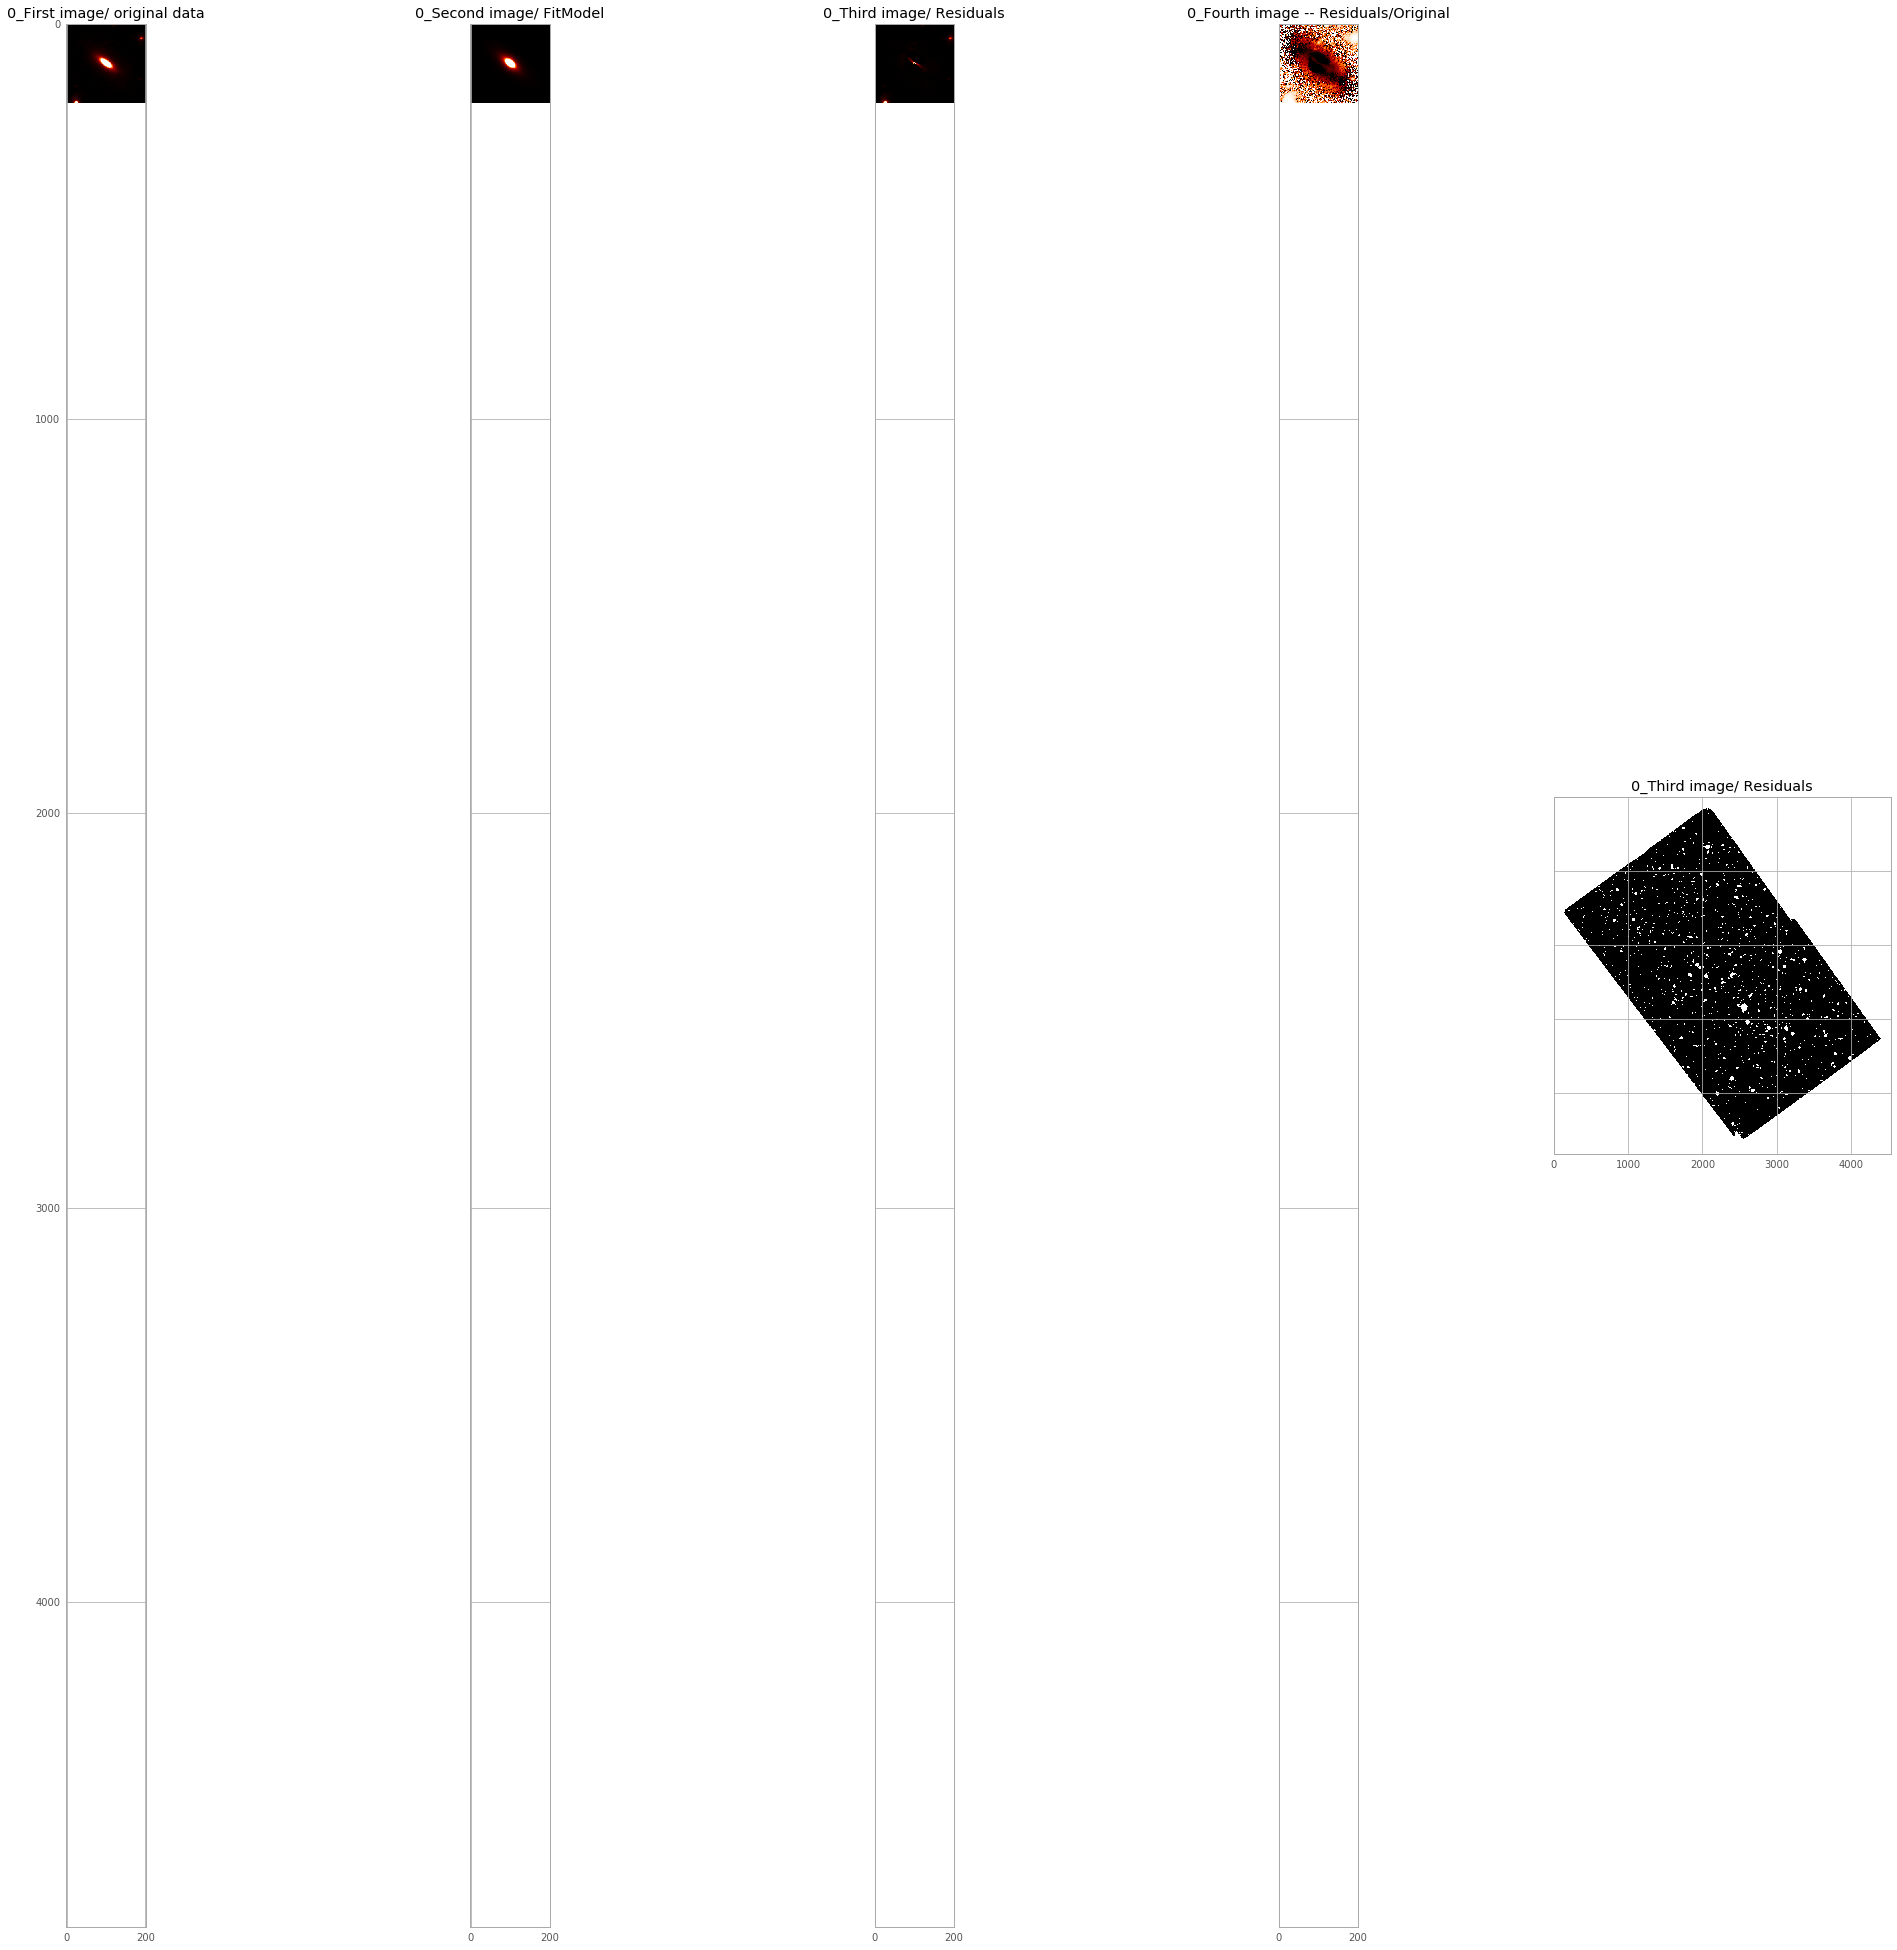

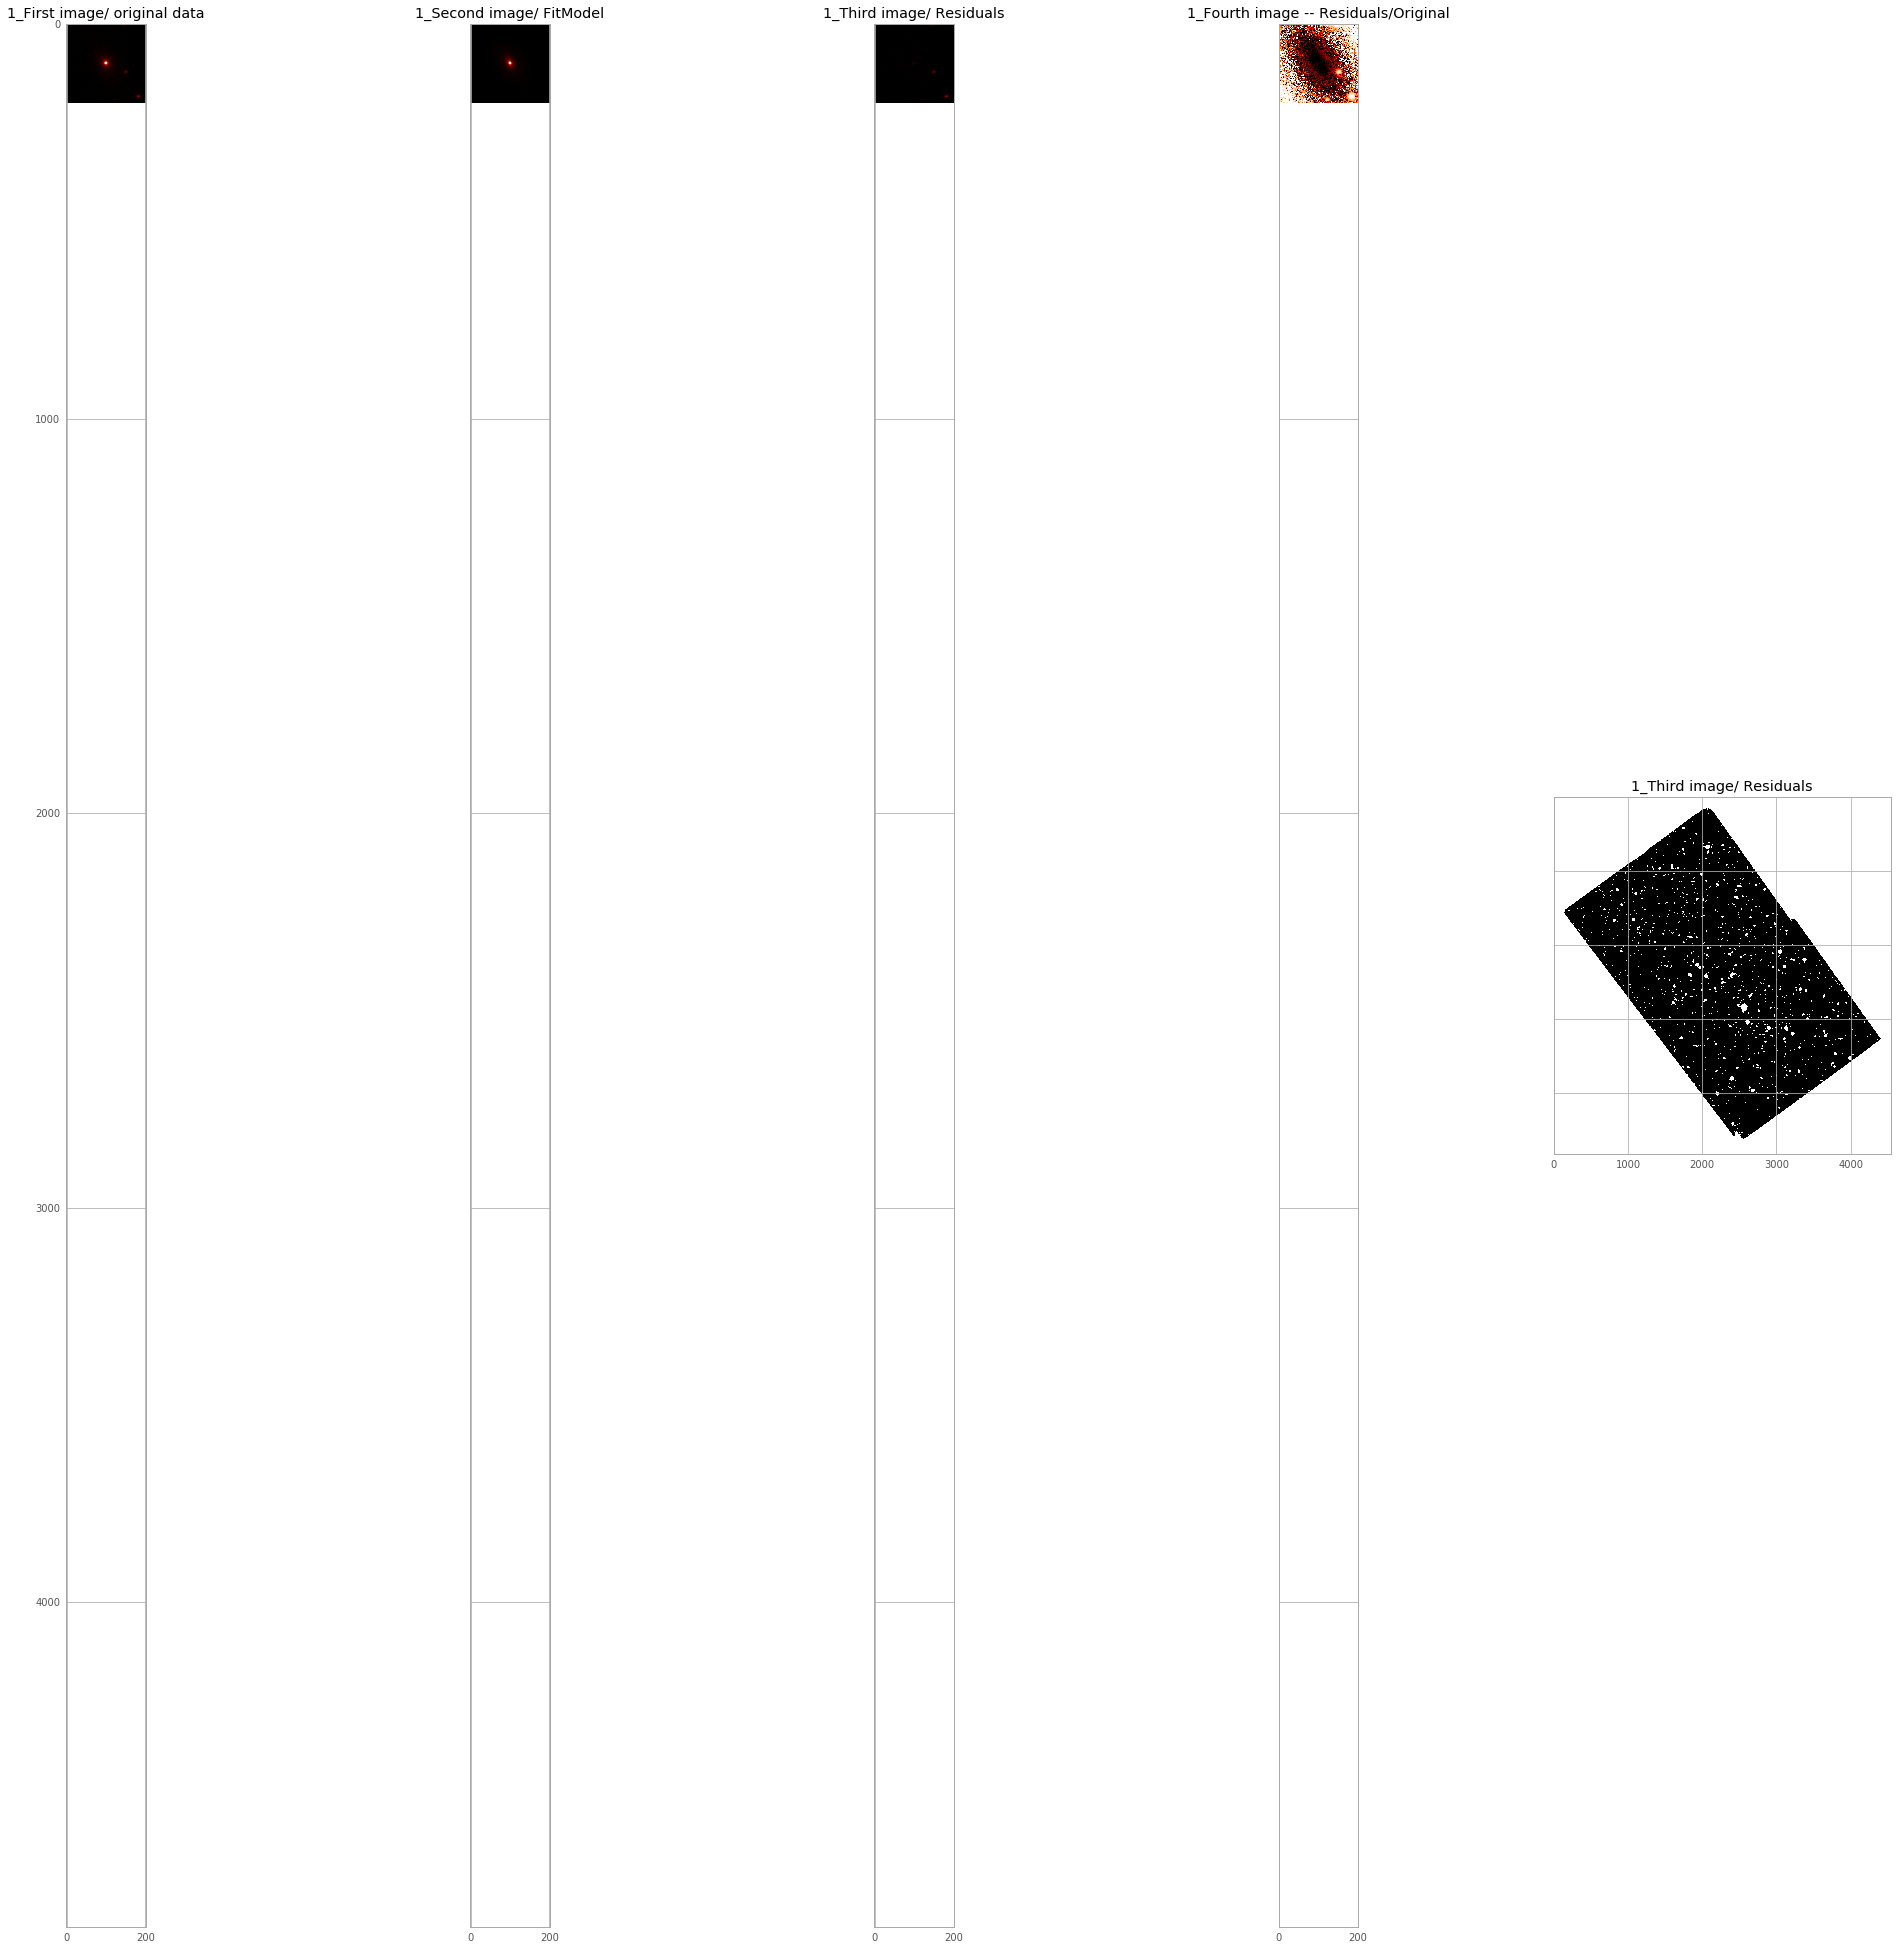

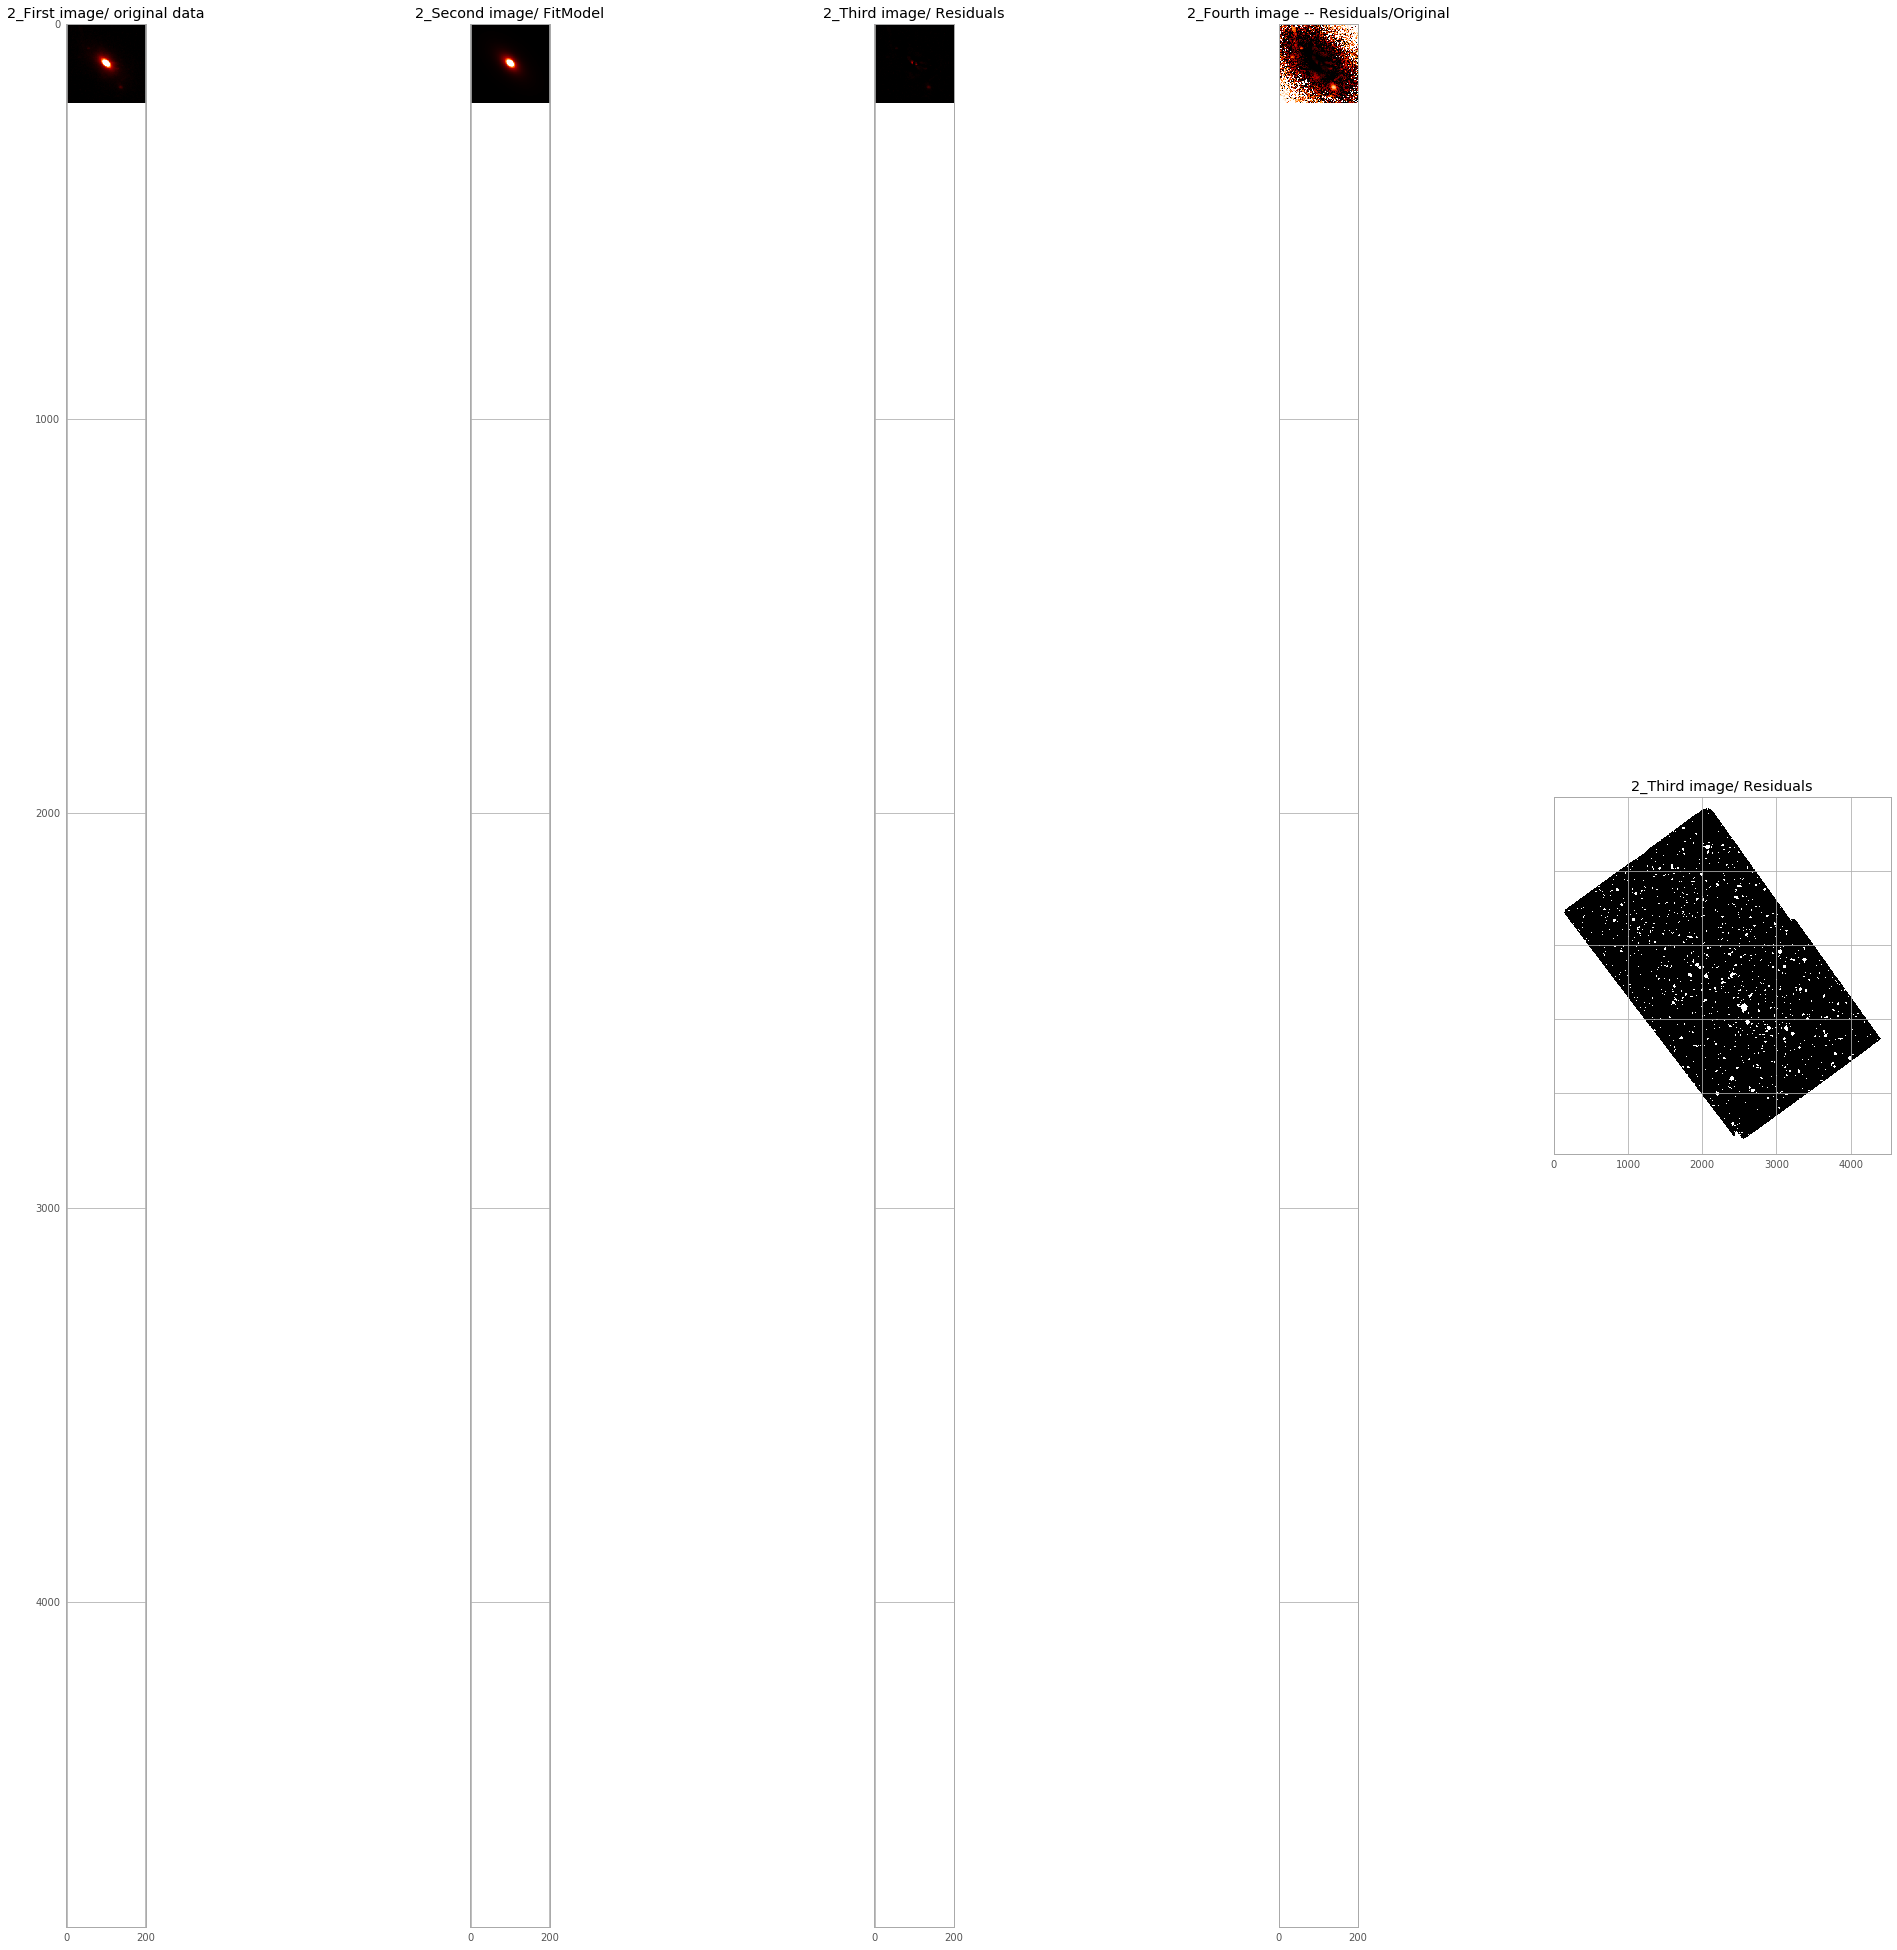

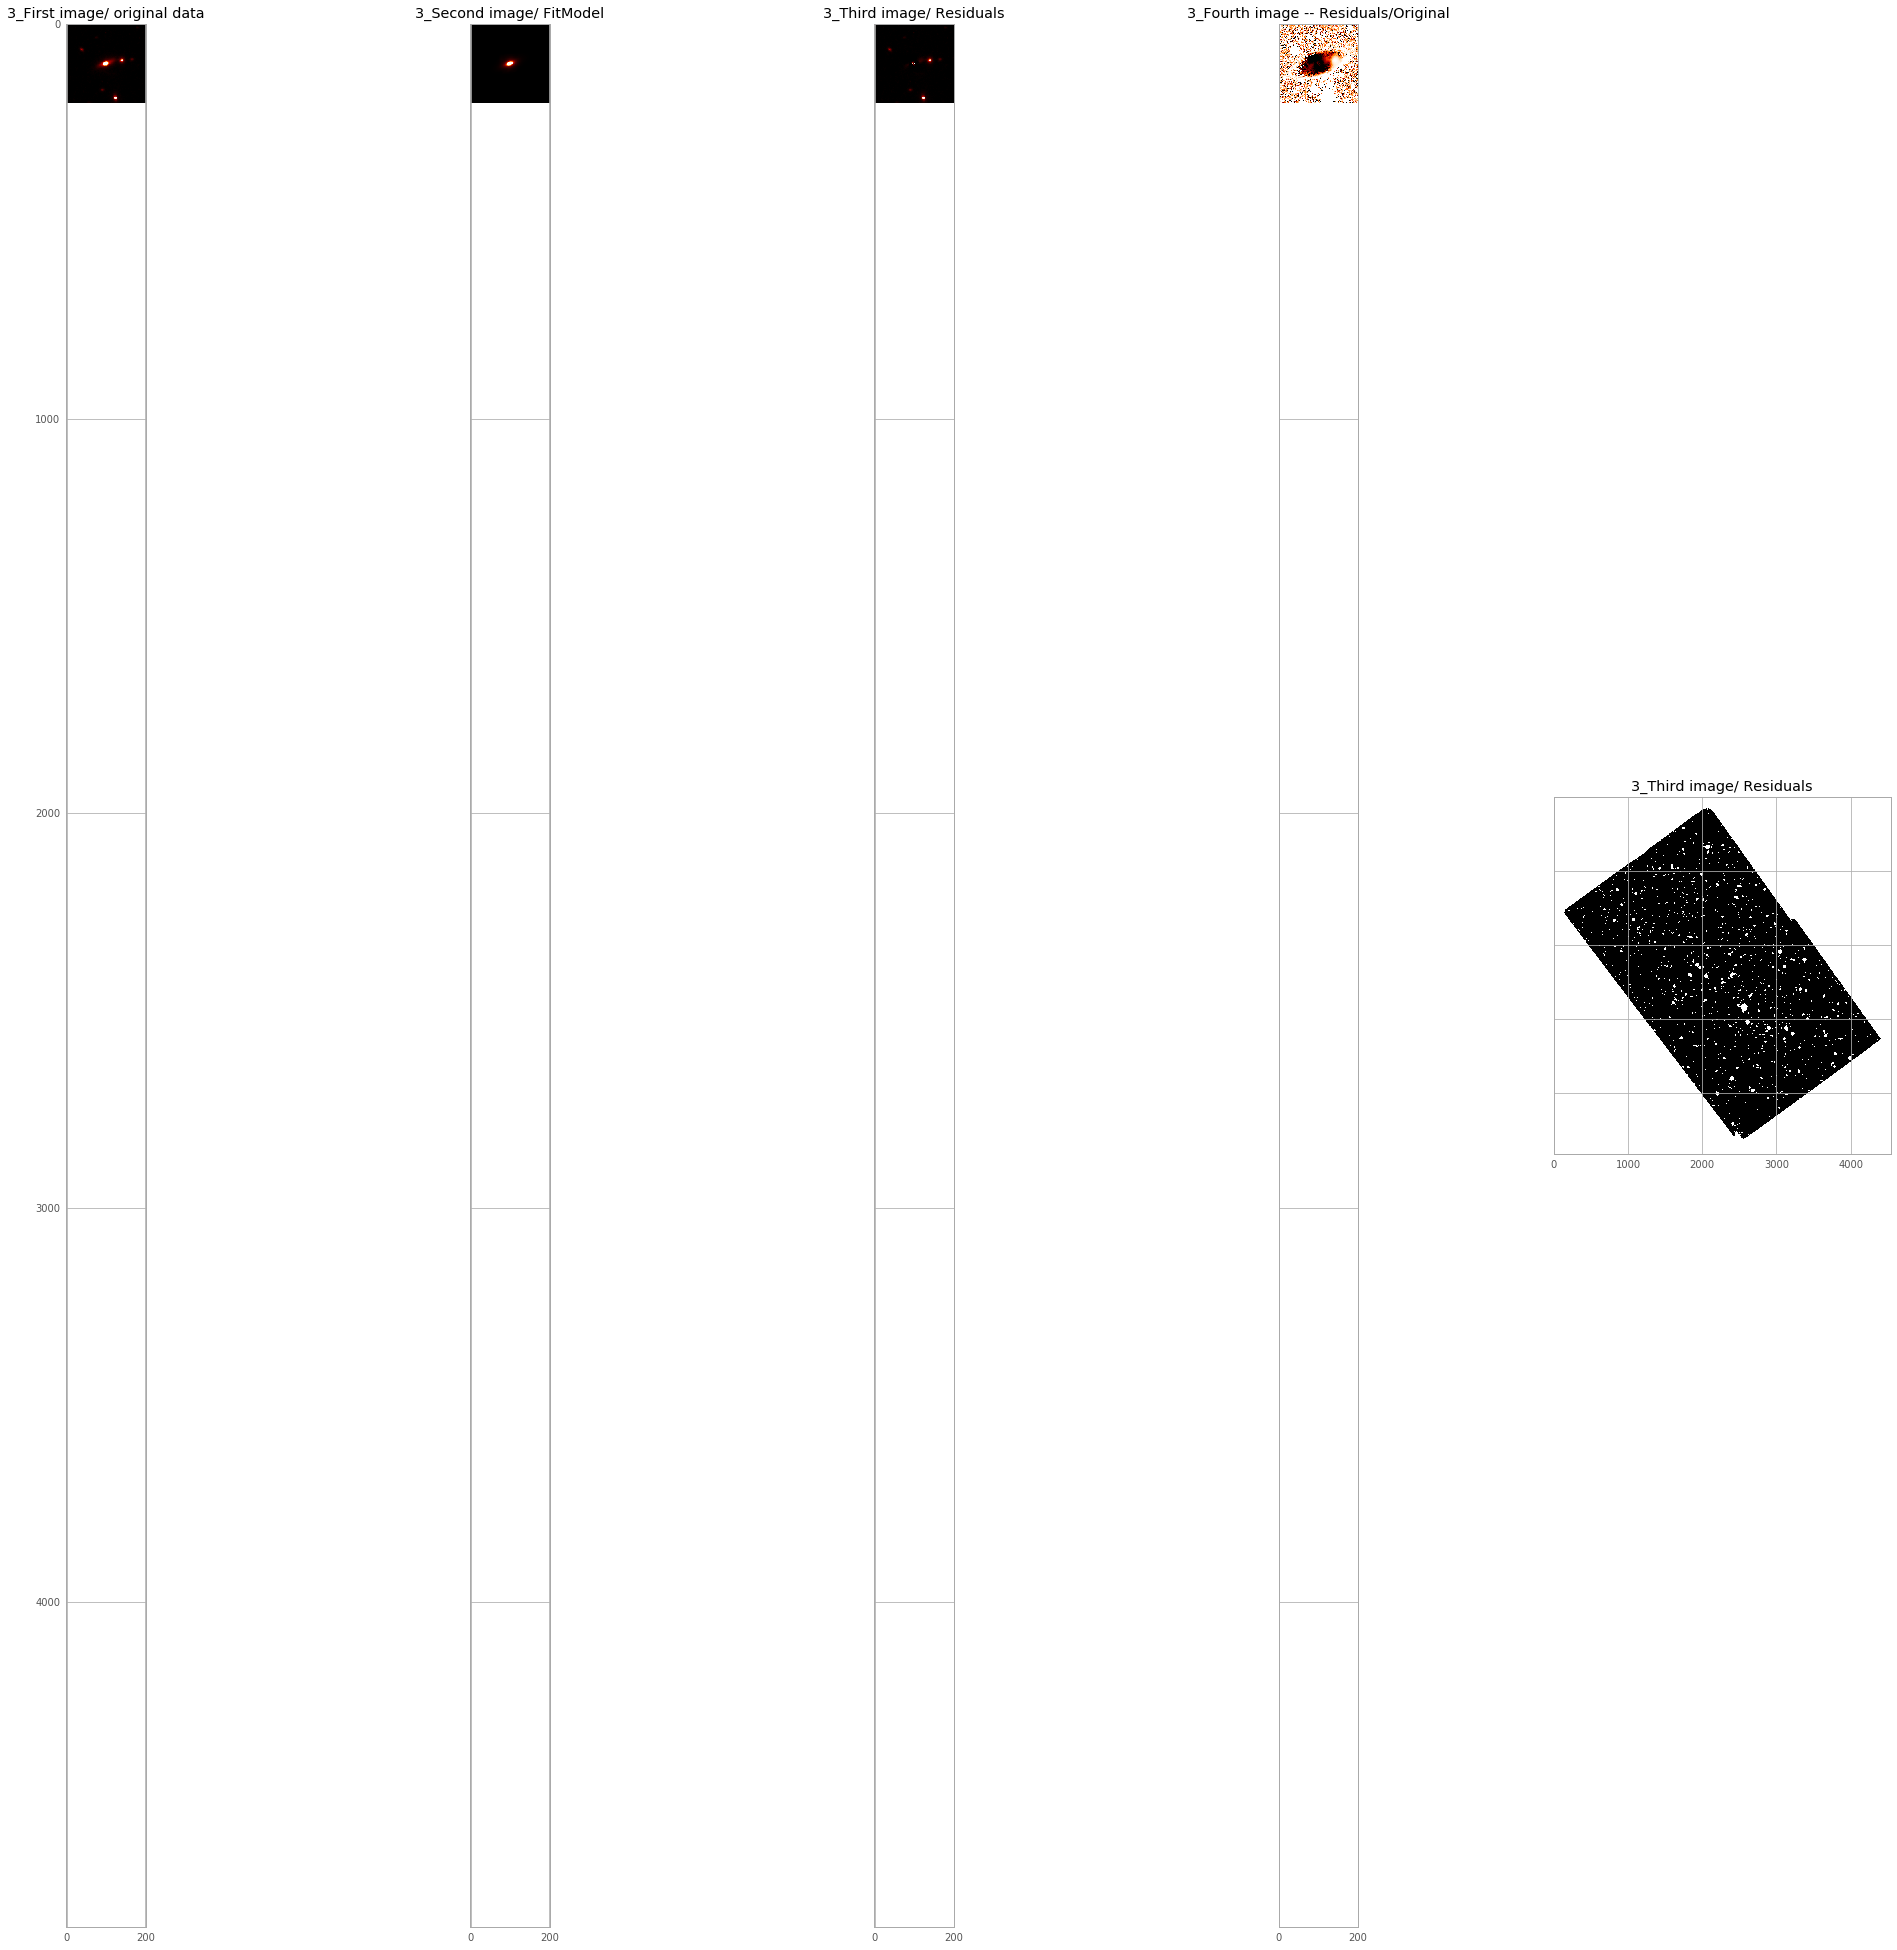

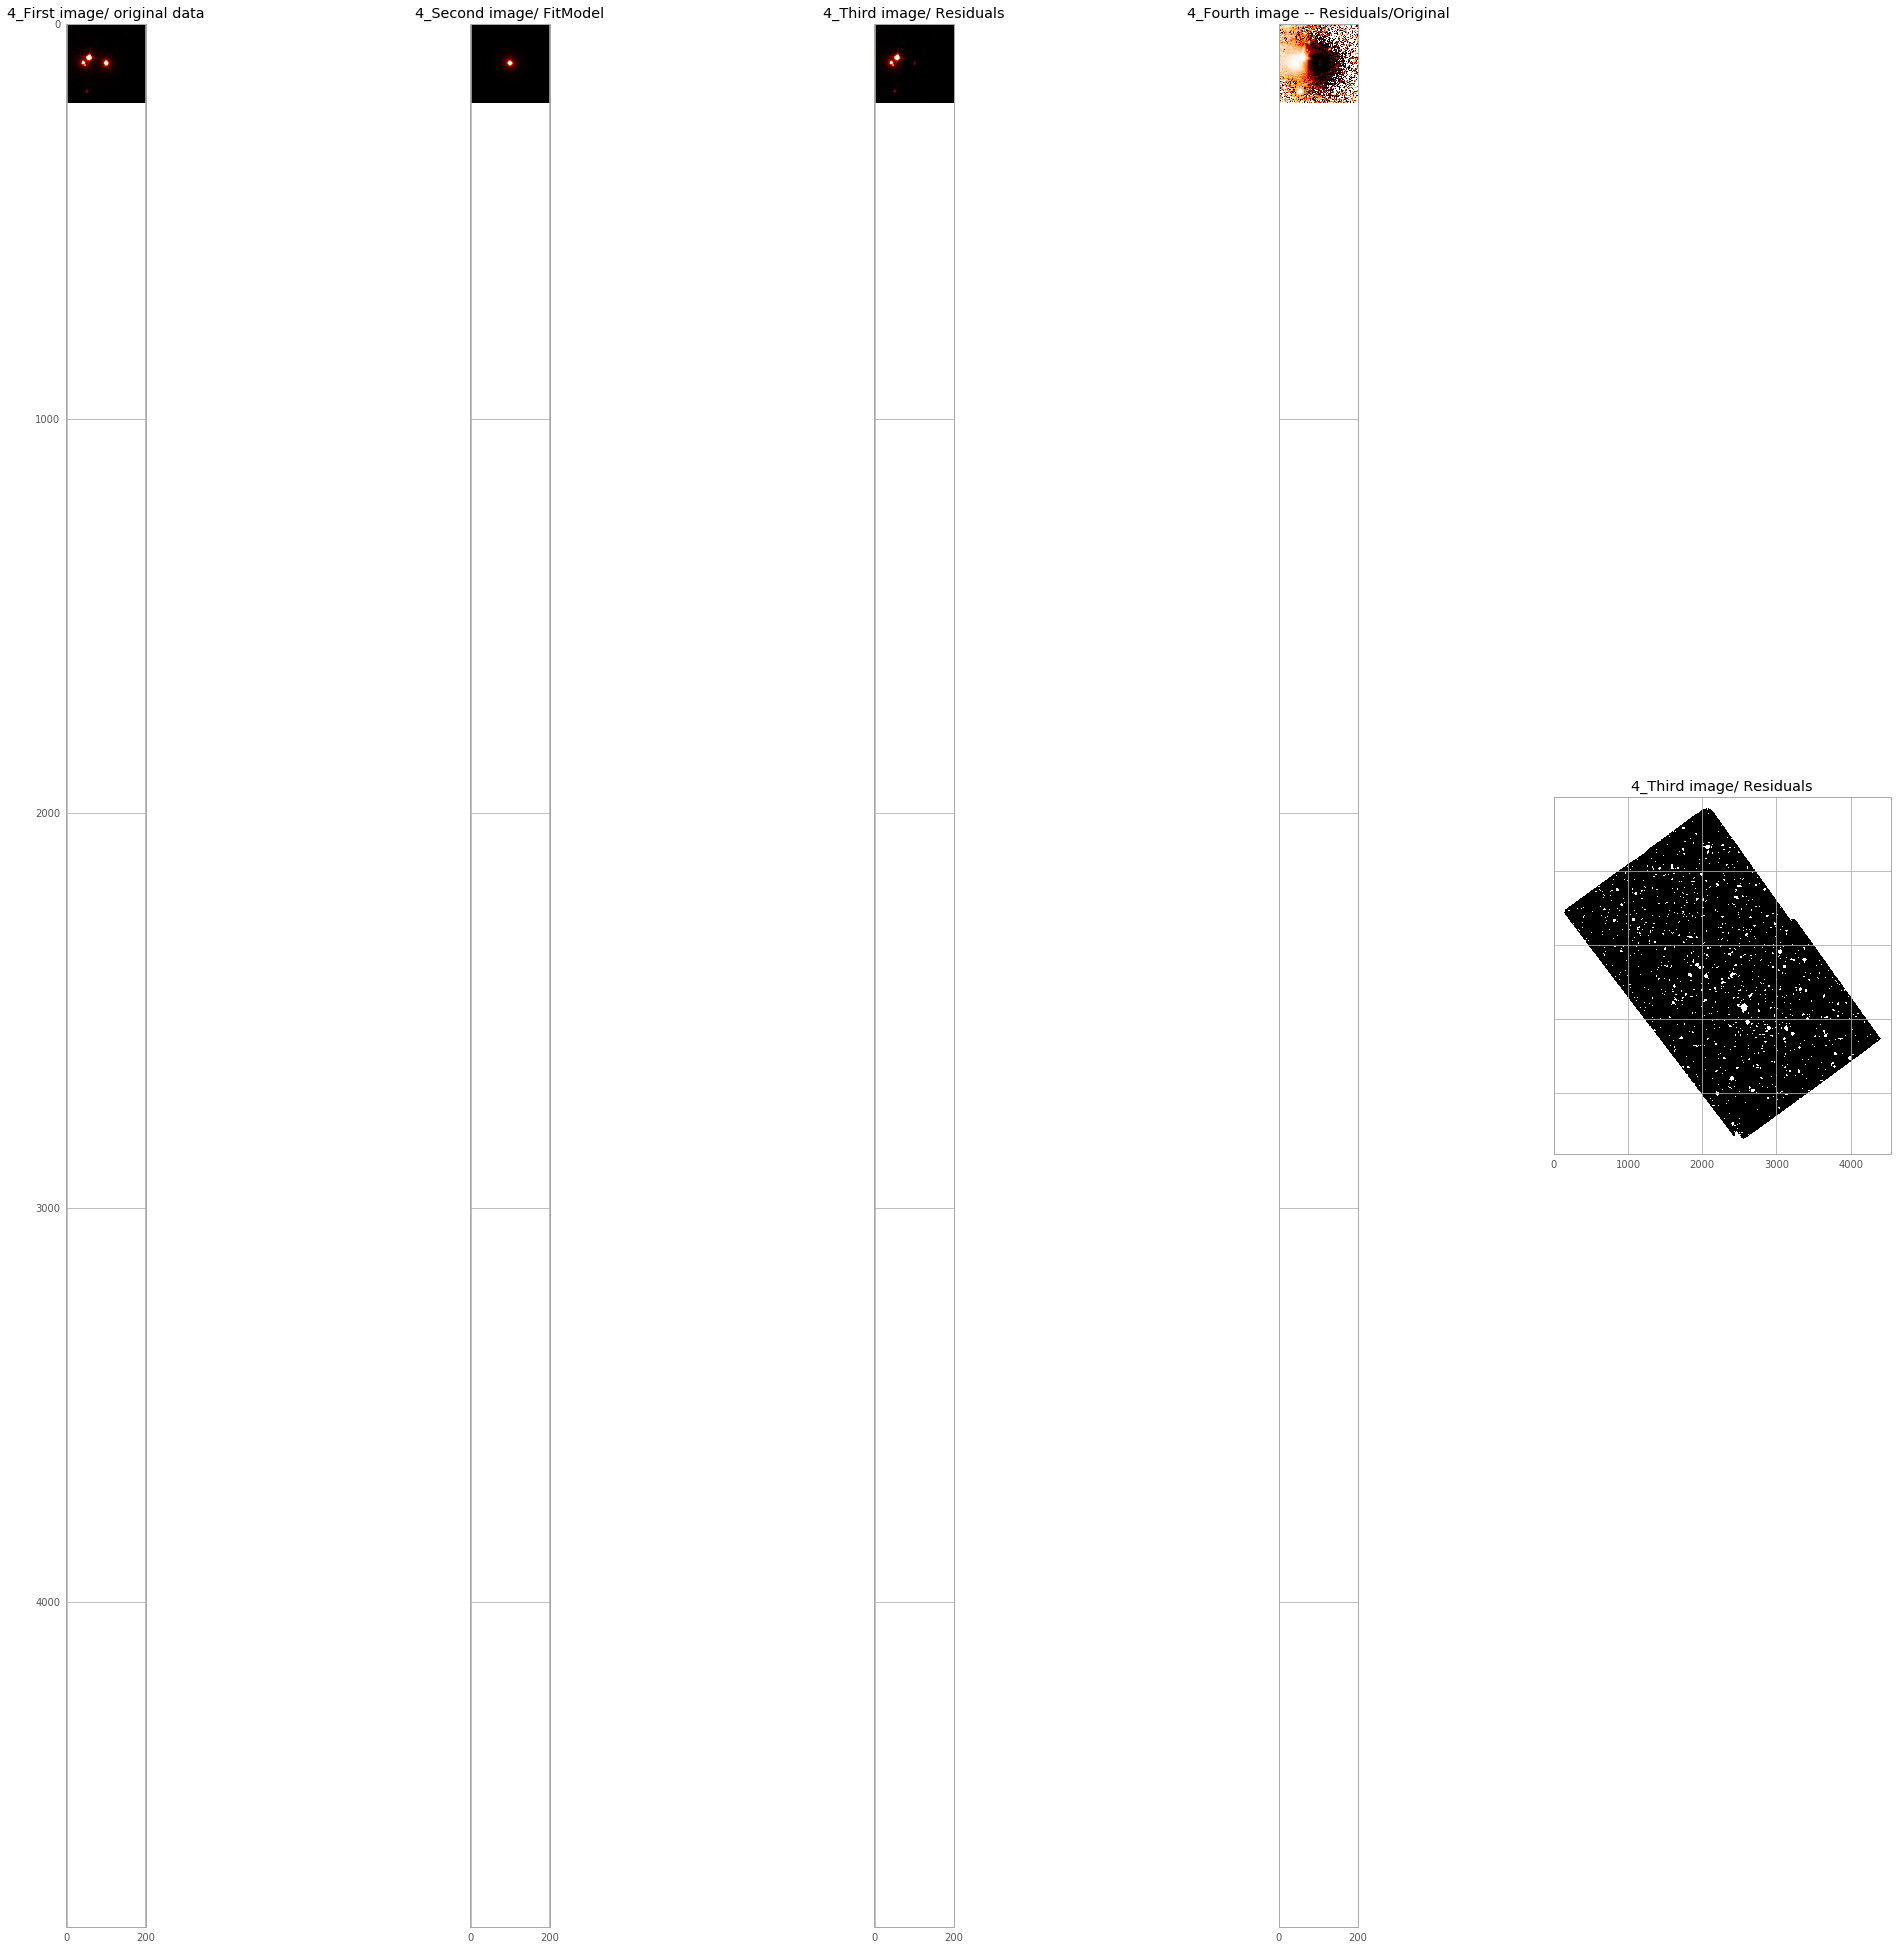

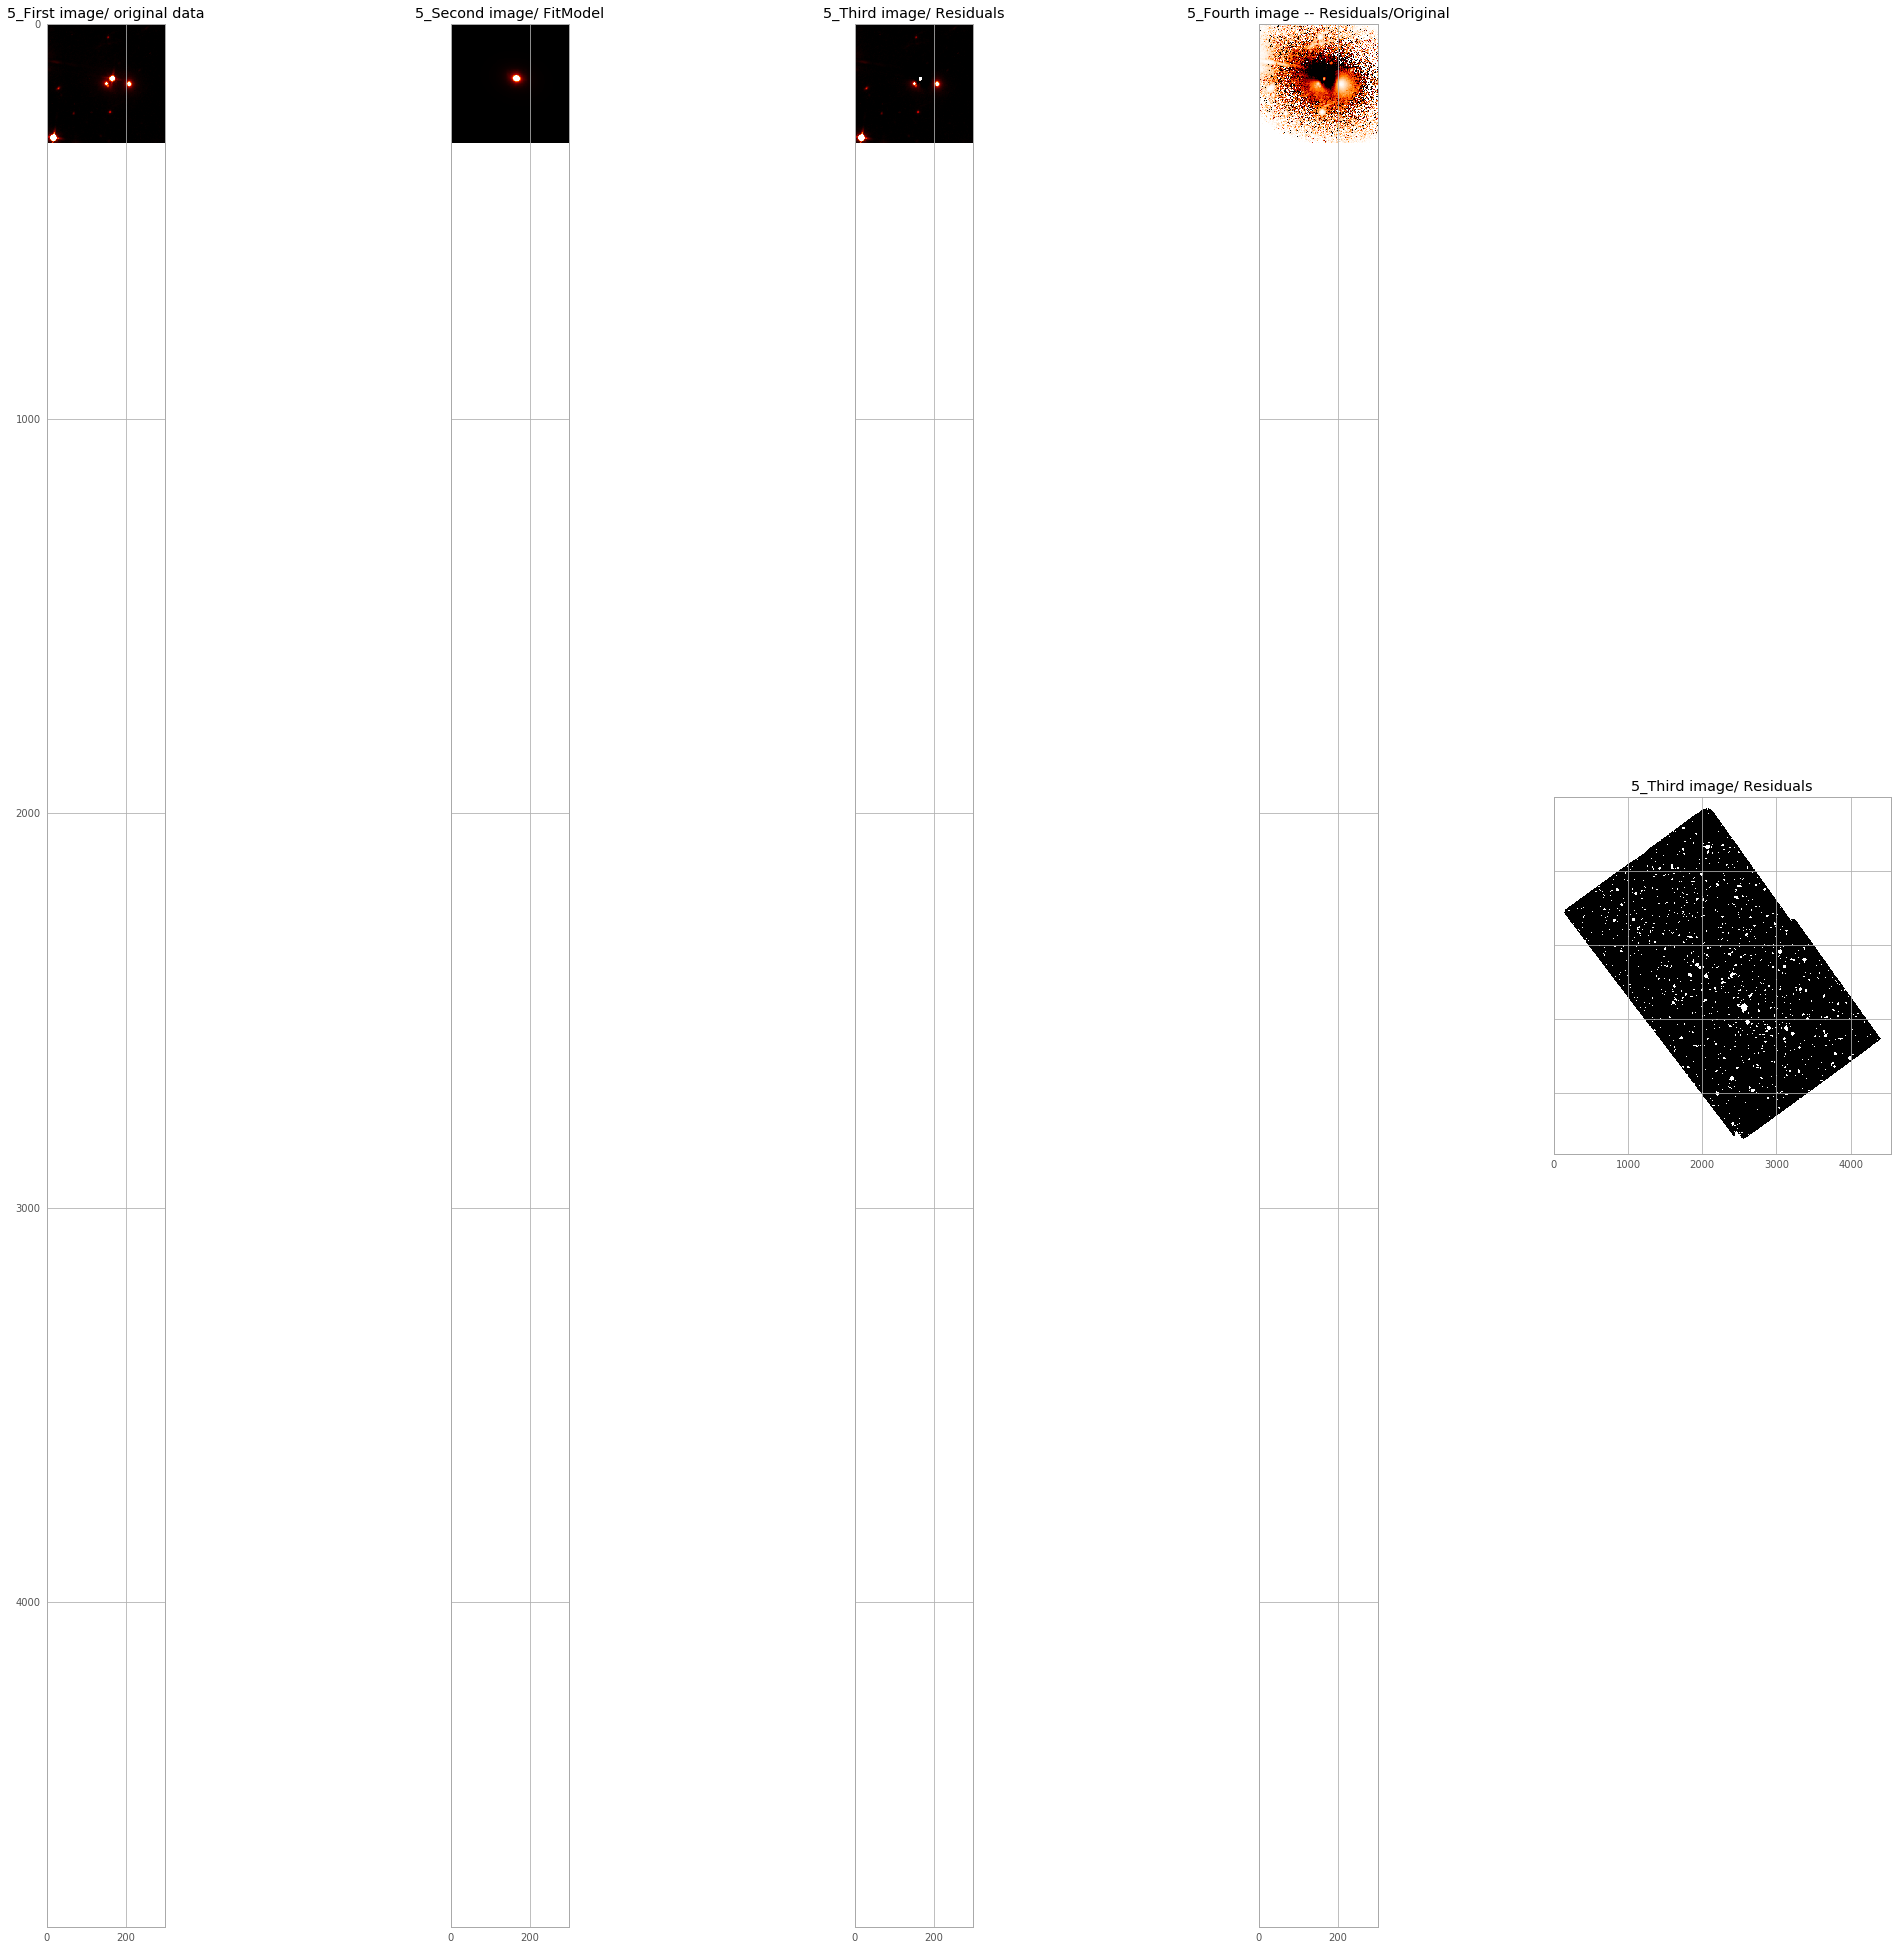

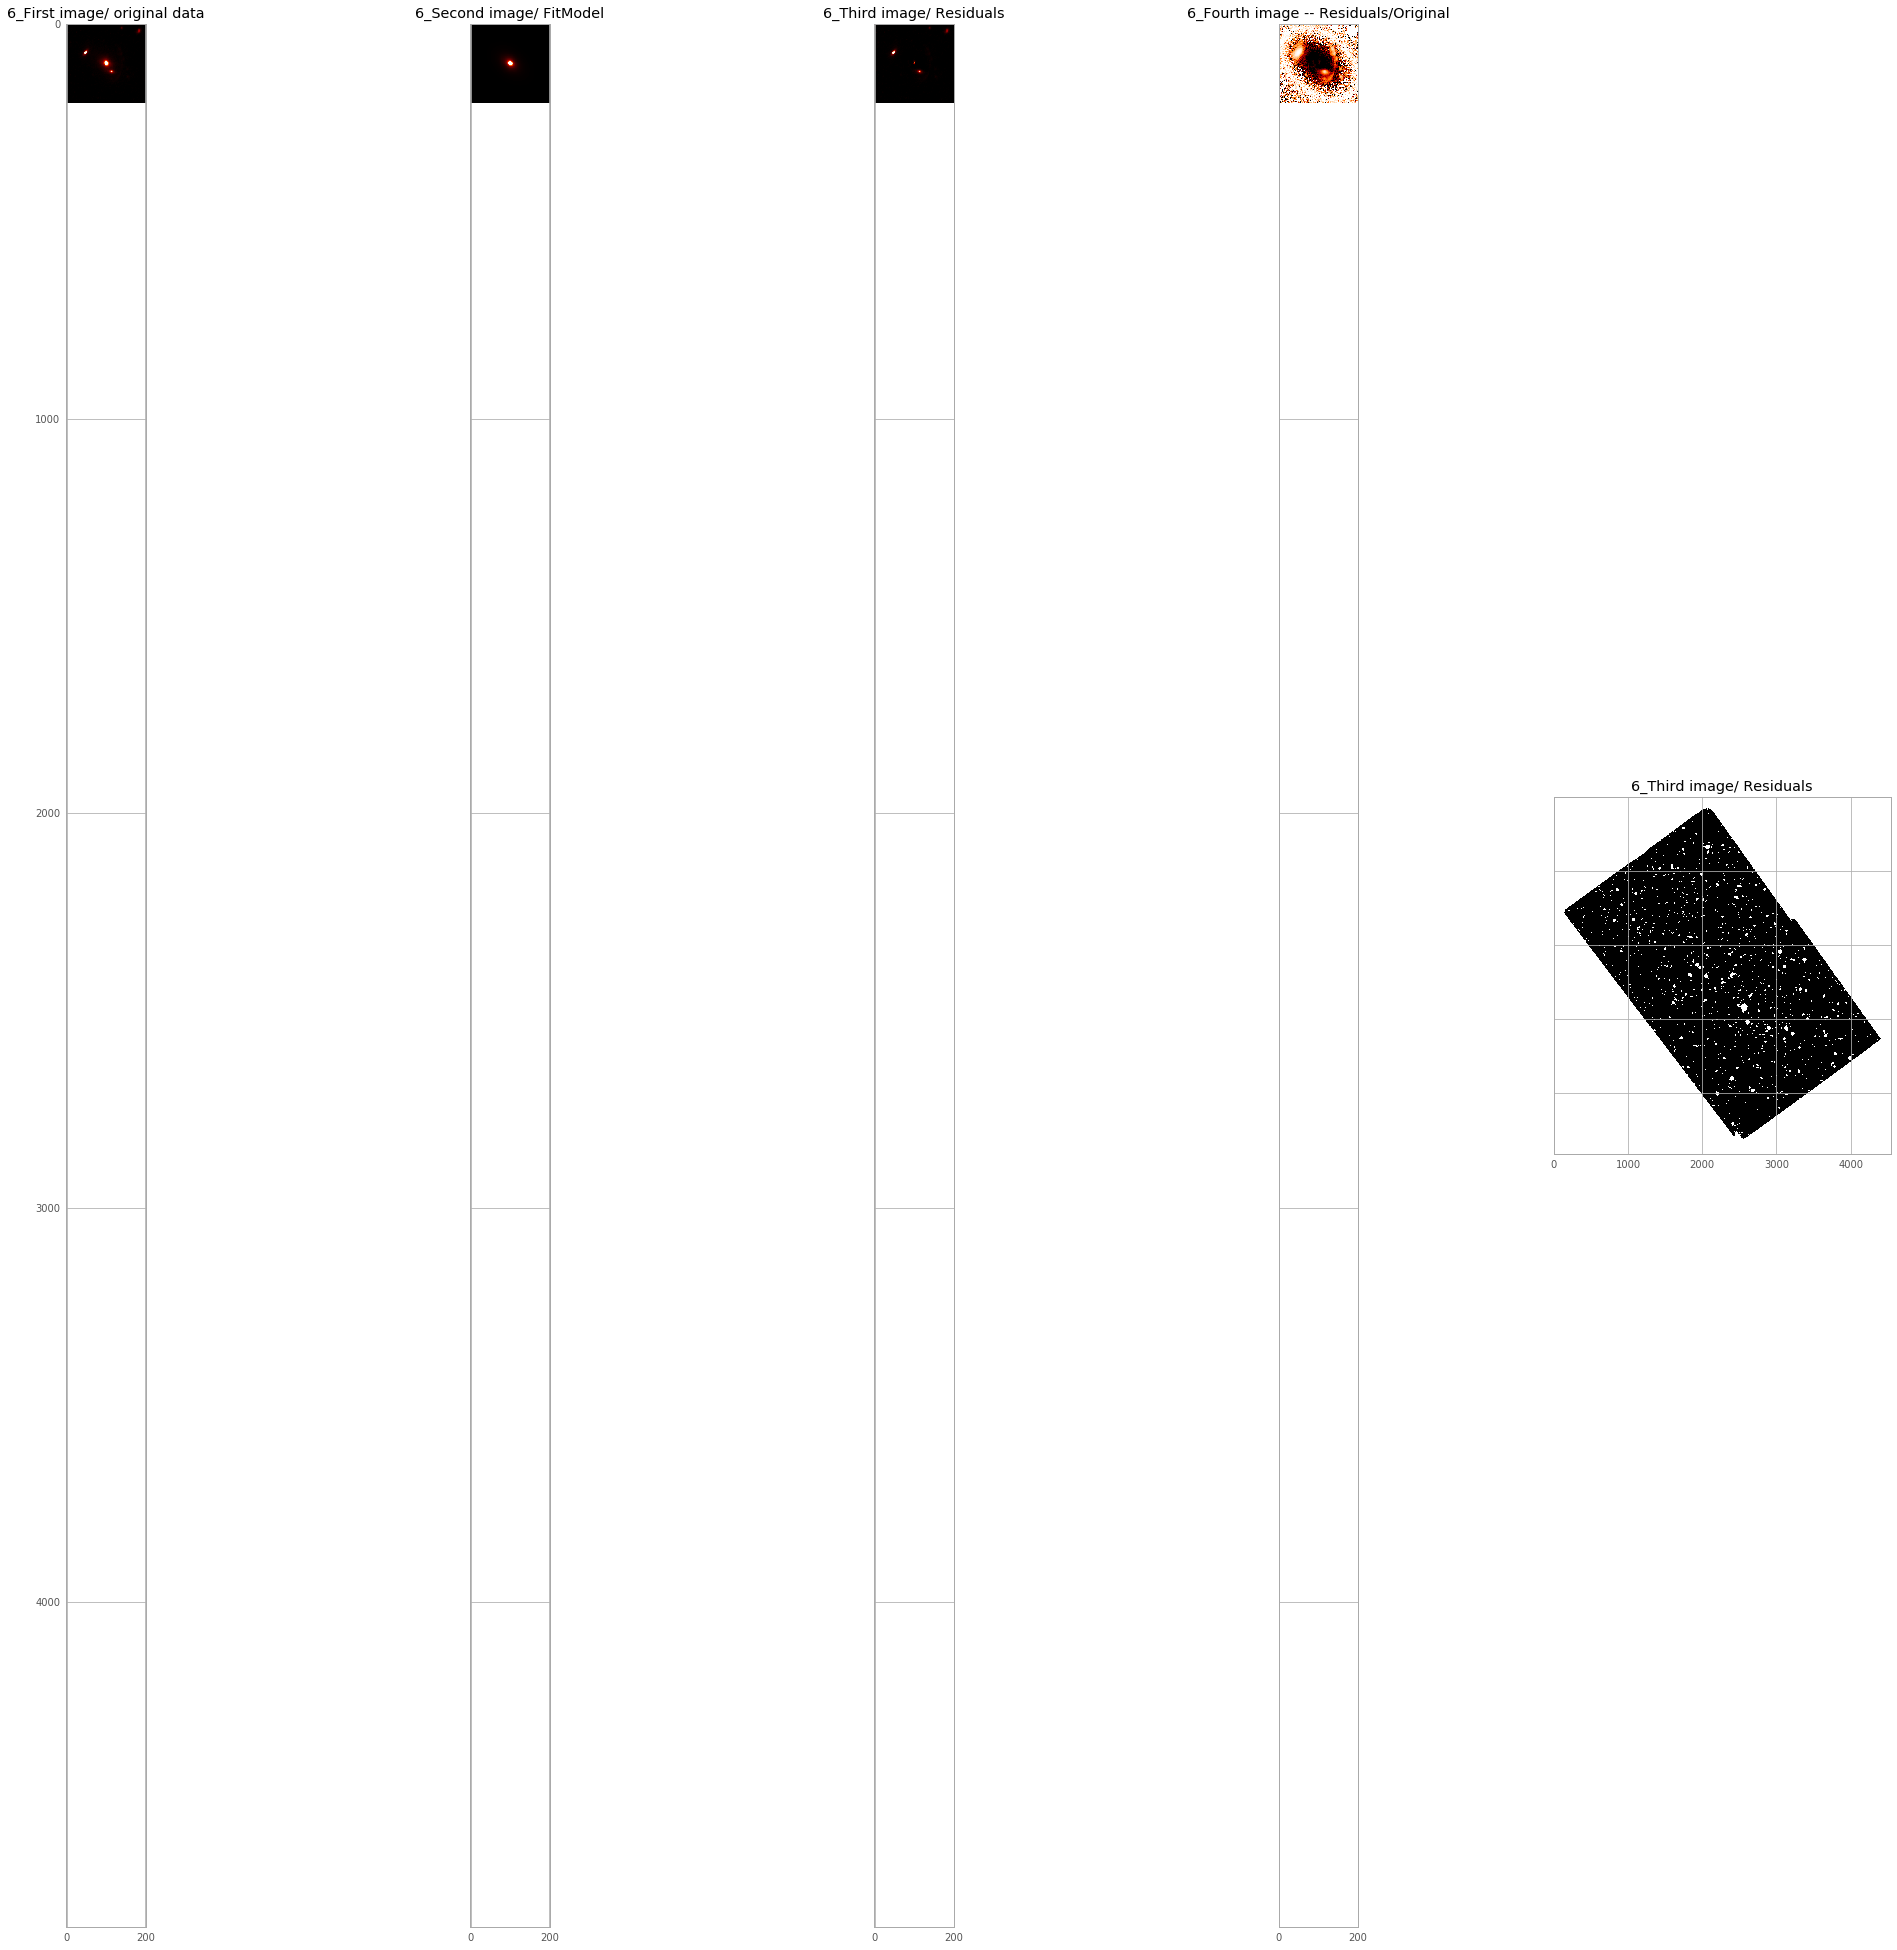

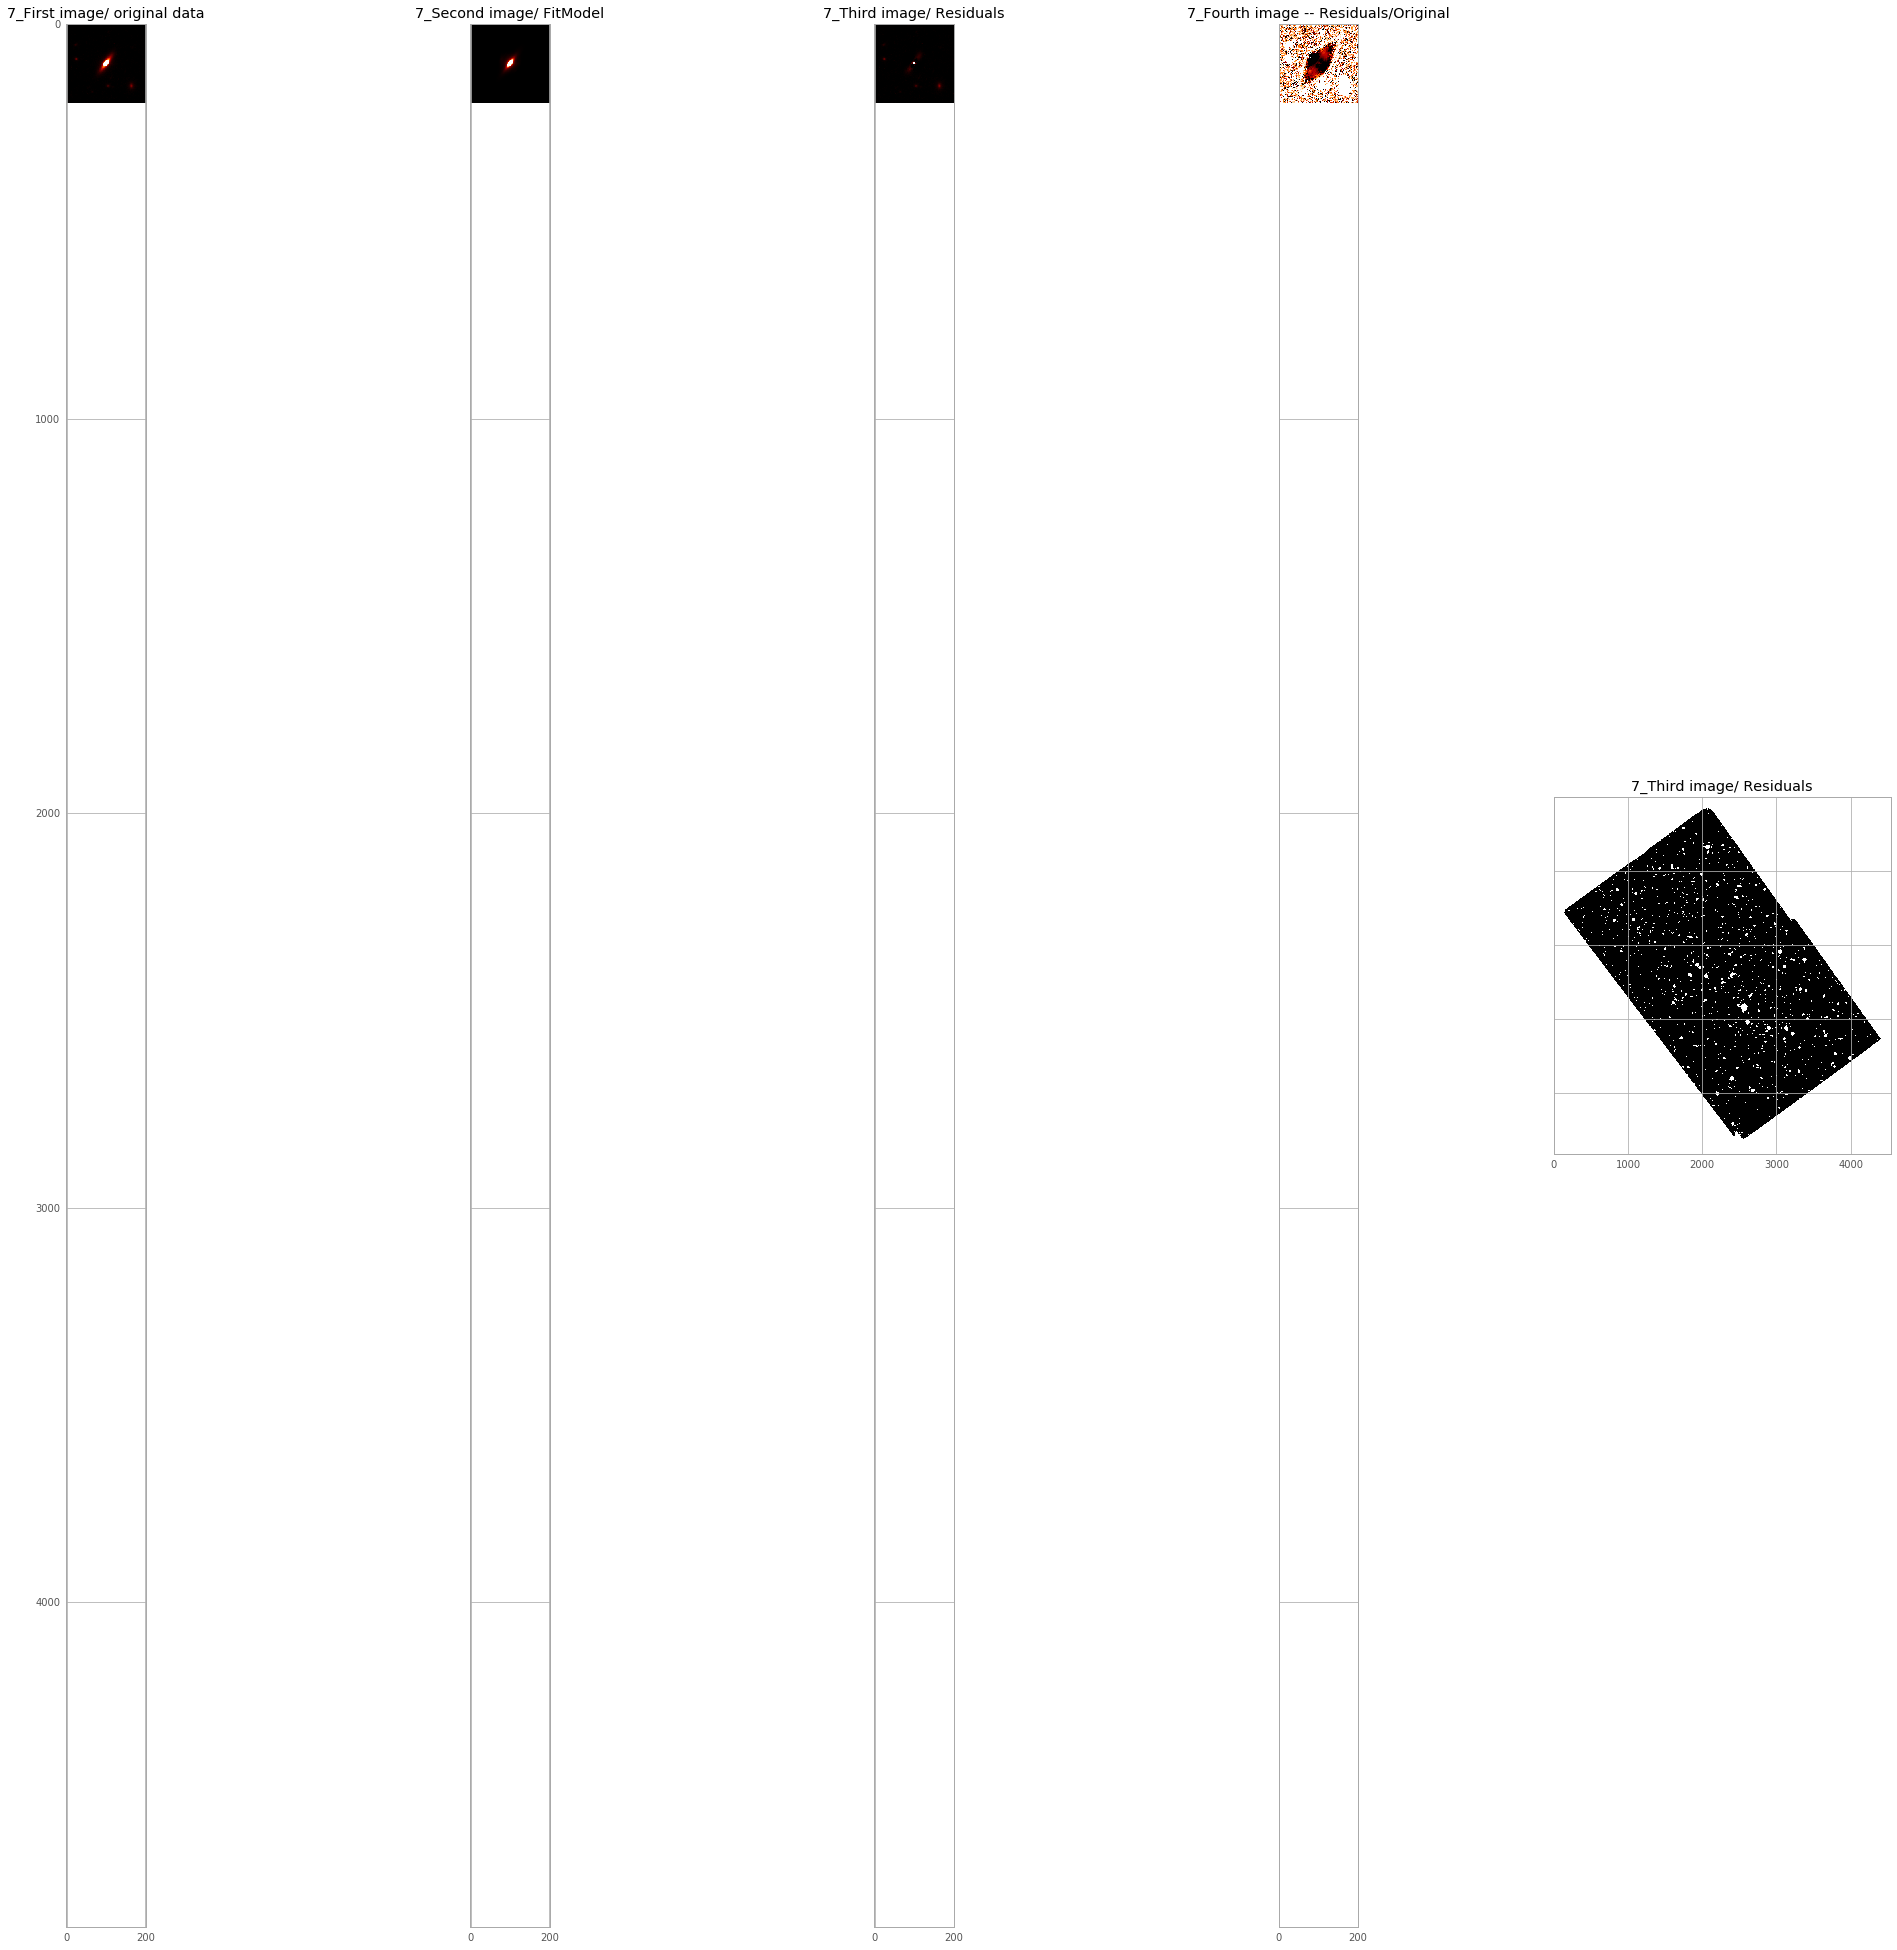

In [12]:
# for count, item in enumerate(modelsList, 0):
#     print(count)
#     image = get_pkg_data_filename('/data1/rowland/F105W_galfit_test_folder/output{}.fits'.format(count))

mask_1 = pyfits.open('/data1/rowland/F105W/dilated_mask.fits')###################
mask = mask_1[0].data


for count, item in enumerate(modelsList, 0):
    print(count)
#change FILTER FOLDER
    #image = get_pkg_data_filename('/data1/rowland/F105W_galfit_test_folder/output{}.fits'.format(count))
    image = get_pkg_data_filename('/data1/rowland/{}/output{}.fits'.format(filtername,count))
    #print('image',image,'info:',type(image))
    #defining each image in output file
    image_1 = pyfits.getdata(image, ext=1) #original
    image_2 = pyfits.getdata(image, ext=2) #model
    image_3 = pyfits.getdata(image, ext=3) #residuals
    image_4 = image_3 / image_1 #original divided by residuals
    #plotting output images
    #f, (ax1,ax2,ax3,ax4) = mpl.subplots(1,4,sharey=True,figsize=(35,35))
    f, (ax1,ax2,ax3,ax4,ax5) = mpl.subplots(1,5,sharey=True,figsize=(35,35))#################
    ax1.imshow(image_1,vmin=0,vmax=1)
    ax1.title.set_text('{}_First image/ original data'.format(count))
    ax2.imshow(image_2,vmin=0,vmax=1)
    ax2.title.set_text('{}_Second image/ FitModel'.format(count))
    ax3.imshow(image_3,vmin=0,vmax=1)
    ax3.title.set_text('{}_Third image/ Residuals'.format(count))
    ax4.imshow(image_4,vmin=0,vmax=1)
    ax4.title.set_text('{}_Fourth image -- Residuals/Original'.format(count))
    ax5.imshow(mask,vmin=0,vmax=1)###########################
    ax5.title.set_text('{}_Third image/ Residuals'.format(count))####################
## manually change location based on filter
    #mpl.savefig('/data1/rowland/F105W_galfit_test_folder/output_images/output{}_galfit_images'.format(count))
    mpl.savefig('/data1/rowland/{}/output{}_galfit_images'.format(filtername,count))

    break #unbreak this after ran all detections through galfit    

    

NameError: name 'plt' is not defined

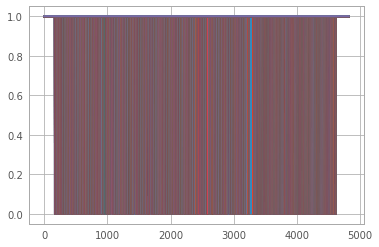

In [9]:

mask_1 = pyfits.open('/data1/rowland/F105W/dilated_mask.fits')###################
mask = mask_1[0].data

for count, item in enumerate(modelsList, 0):
 
    mpl.plot(mask)
    w=150
    xs = xs[count]
    ys = ys[count]
    plt.xlim(xs-w, xs + w)
    plt.ylim(ys-w, ys + w)
    break